# Fatal Police Shooting in the United States

## Loading Datasets

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

import folium
from geopy.geocoders import Nominatim
from folium import plugins
from folium.plugins import HeatMap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

%config InlineBackend.figure_format = 'retina'
sns.set()
%matplotlib inline


In [107]:
sns.set_style("darkgrid")
sns.set_context("talk")
sns.set_palette("colorblind")

In [108]:
shootings_df=pd.read_csv('https://raw.githubusercontent.com/vadimiljin/capstone1/master/updated-fatal-police-shootings-data.csv')
shootings_df.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True


In [109]:
shootings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7743 entries, 0 to 7742
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7743 non-null   int64  
 1   name                     7321 non-null   object 
 2   date                     7743 non-null   object 
 3   manner_of_death          7743 non-null   object 
 4   armed                    7534 non-null   object 
 5   age                      7258 non-null   float64
 6   gender                   7722 non-null   object 
 7   race                     6271 non-null   object 
 8   city                     7743 non-null   object 
 9   state                    7743 non-null   object 
 10  signs_of_mental_illness  7743 non-null   bool   
 11  threat_level             7743 non-null   object 
 12  flee                     6866 non-null   object 
 13  body_camera              7743 non-null   bool   
 14  longitude               

Checking how many features and rows we have as well as what kind of data types we have. 

## Data cleaning

#### Percentage of missing data.

In [110]:
missing_data = shootings_df.isna().mean().round(3)
missing_data


id                         0.000
name                       0.055
date                       0.000
manner_of_death            0.000
armed                      0.027
age                        0.063
gender                     0.003
race                       0.190
city                       0.000
state                      0.000
signs_of_mental_illness    0.000
threat_level               0.000
flee                       0.113
body_camera                0.000
longitude                  0.001
latitude                   0.001
is_geocoding_exact         0.000
dtype: float64

Checking if dataset has any duplicates. As mentioned in github id is a unique identifier for each victim.

In [111]:
shootings_df.duplicated(subset="id").any()

False

Filling missing values in name, race, flee columns with 'unknown' because in https://github.com/washingtonpost/data-police-shootings README.md it says if it is None it means it is unknown. Also filling Nan's in armed column with 'undertermined'.

In [112]:
unknown_columns = ["name", "race", "flee"]

for row in unknown_columns:
    shootings_df[row].fillna("unknown", inplace=True)


In [113]:
shootings_df["armed"].fillna("undetermined", inplace=True)


Changing date column to an appropriate type

In [114]:
shootings_df["date"] = pd.to_datetime(shootings_df["date"])


In [115]:
shootings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7743 entries, 0 to 7742
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       7743 non-null   int64         
 1   name                     7743 non-null   object        
 2   date                     7743 non-null   datetime64[ns]
 3   manner_of_death          7743 non-null   object        
 4   armed                    7743 non-null   object        
 5   age                      7258 non-null   float64       
 6   gender                   7722 non-null   object        
 7   race                     7743 non-null   object        
 8   city                     7743 non-null   object        
 9   state                    7743 non-null   object        
 10  signs_of_mental_illness  7743 non-null   bool          
 11  threat_level             7743 non-null   object        
 12  flee                     7743 non-

Won't be filling in age missing values so it doesn't mess up distribution plots.There are still some missing coordinates so after finding them I'll have to fill them manually.

In [116]:
shootings_df[shootings_df["longitude"].isna()]


,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
2919,3247,Salvador Byassee,2017-12-26,shot,knife,34.0,M,unknown,300 block of State Line Road,TN,False,other,Other,False,NaN,NaN,True
4952,5499,Joshua Franklin Roberts,2020-01-09,shot,gun,41.0,M,W,Powatan Point,OH,False,other,Car,False,NaN,NaN,True
6033,7520,Gilbert Valencia,2021-02-03,shot,toy weapon,29.0,M,H,Demming,NM,True,other,Not fleeing,False,NaN,NaN,True
6903,7384,Adam McKnight,2021-11-28,shot,machete,33.0,M,W,Winstom-Salem,NC,True,other,Not fleeing,False,NaN,NaN,True
7518,8184,Joy Ann Taylor-Graham,2022-06-24,shot,gun,47.0,F,unknown,Gurnsey County,OH,False,attack,Car,False,NaN,NaN,True
7594,8261,Hamed Ghorouni,2022-07-20,shot,knife,35.0,M,unknown,Gaitherburg,MD,False,other,Not fleeing,False,NaN,NaN,True


In [117]:
# Update index 2919 Salvador Byassee
shootings_df.at[2919, "latitude"] = 36.3429
shootings_df.at[2919, "longitude"] = -88.7109

# Update index 4952 Joshua Franklin Roberts
shootings_df.at[4952, "latitude"] = 39.8601
shootings_df.at[4952, "longitude"] = -80.8154

# Update index 6033 Gilbert Valencia
shootings_df.at[6033, "latitude"] = 32.2567
shootings_df.at[6033, "longitude"] = -107.7535

# Update index 6903 Adam McKnight
shootings_df.at[6903, "latitude"] = 36.099861
shootings_df.at[6903, "longitude"] = -80.244217

# Update index 7410 Carlos Tovar Gamboa
shootings_df.at[7410, "latitude"] = 32.3073
shootings_df.at[7410, "longitude"] = -106.7737

# Update index 7518 Joy Ann Taylor-Graham
shootings_df.at[7518, "latitude"] = 39.988126
shootings_df.at[7518, "longitude"] = -81.176496

# Update index 7594 Hamed Ghorouni
shootings_df.at[7594, "latitude"] = 39.1434406
shootings_df.at[7594, "longitude"] = -77.2013705



In [118]:
shootings_df["longitude"].isna().any()


False

In [119]:
shootings_df['race'].unique()

array(['A', 'W', 'H', 'B', 'O', 'unknown', 'N'], dtype=object)

I'll change the letters of race column to full names of races, so it will look better on graphs and charts.

In [120]:
shootings_df["race"].replace(
    {
        "A": "Asian",
        "B": "Black",
        "H": "Hispanic",
        "W": "White",
        "O": "Other",
        "N": "Native American",
    },
    inplace=True,
)

Also I will be using another dataset of America's state's population which I found on https://worldpopulationreview.com/states to find deaths per capita (100K POP) and to calculate race proportions.

In [121]:
population_df = pd.read_csv(
    "https://raw.githubusercontent.com/vadimiljin/capstone1/master/population.csv"
)

In [122]:
population_df.head()


,NAME,STATE_ABB,ESTIMATESBASE2022
0,Alaska,AK,738023
1,Alabama,AL,5073187
2,Arkansas,AR,3030646
3,Arizona,AZ,7303398
4,California,CA,39995077


In order to make another DataFrame with deaths per capita I need to find how many deaths each state by making another DataFrame has and to concat the newly loaded dataset with the one I just made.

In [123]:
states_df = shootings_df.groupby("state").count()

states_df["DEATHS"] = states_df["id"]
states_df = states_df[["DEATHS"]].reset_index()
full_df = pd.concat([population_df, states_df], axis=1)
full_df.drop("STATE_ABB", axis=1, inplace=True)
full_df.rename(columns={"ESTIMATESBASE2022": "POPULATION"}, inplace=True)
full_df.rename(columns={"state": "STATE"}, inplace=True)
full_df.index = full_df["NAME"]
full_df.drop("NAME", axis=1, inplace=True)
full_df["DEATHS_PER_STATE_CAPITA"] = full_df["DEATHS"] / full_df["POPULATION"] * 100000

Another dataset that I'm going to use is Strictest Gun Laws by State 2022 dataset. 
https://worldpopulationreview.com/state-rankings/strictest-gun-laws-by-state

In [124]:
gun_law_df = pd.read_csv(
    "https://raw.githubusercontent.com/vadimiljin/capstone1/master/gun-laws.csv",
    index_col=0,
)

## EDA

### Describing the data

First let's find out time period of this dataset.

#### Dates

In [125]:
print(f"Data dates from {min(shootings_df.date)} to {max(shootings_df.date)}")

Data dates from 2015-01-02 00:00:00 to 2022-09-12 00:00:00


Now we know that we have 7 years of fatal police shootings data.

#### Age feature

In [126]:
shootings_df.describe().apply(lambda x: x.apply("{:n}".format))["age"]

count       7258
mean     37.1801
std      12.9604
min            2
25%           27
50%           35
75%           45
max           92
Name: age, dtype: object

By using .describe() function we can see that we have 7258 datapoints from which minimum age is 2 years old and maximum age is 92. Also average age of those who got killed is 37 years.

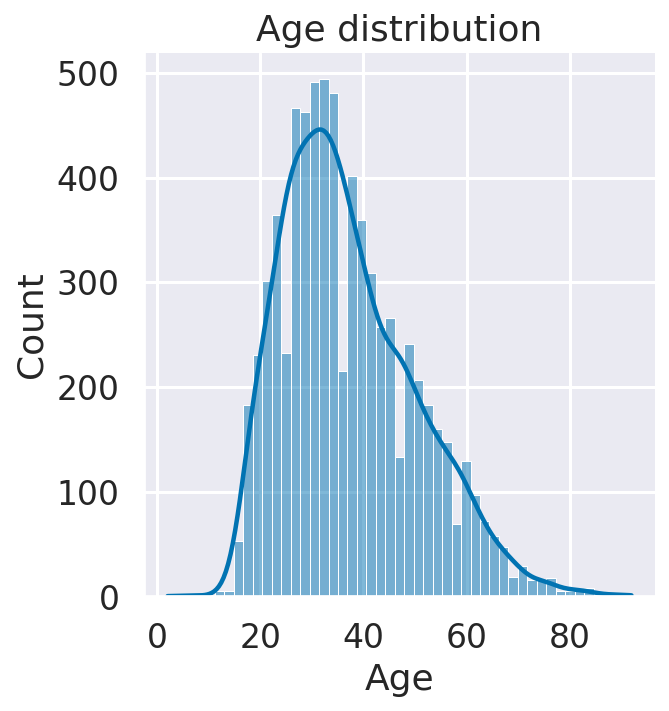

In [127]:
sns.displot(data=shootings_df["age"], kde=True)

plt.title("Age distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


#### Deaths feature

In [128]:
full_df.describe().apply(lambda x: x.apply("{:n}".format))["DEATHS"]


count         51
mean     151.824
std      185.648
min            6
25%         48.5
50%          117
75%        163.5
max         1115
Name: DEATHS, dtype: object

Here we see that we have data from 51 states, mean is 151 deaths, but standart deviation is really high so our mean isn't that useful to tell something about the states. We have to look at quartiles. Here we see that about 75% of states have a higher deaths than the average and the rest 25% of states makes the mean to be like that.

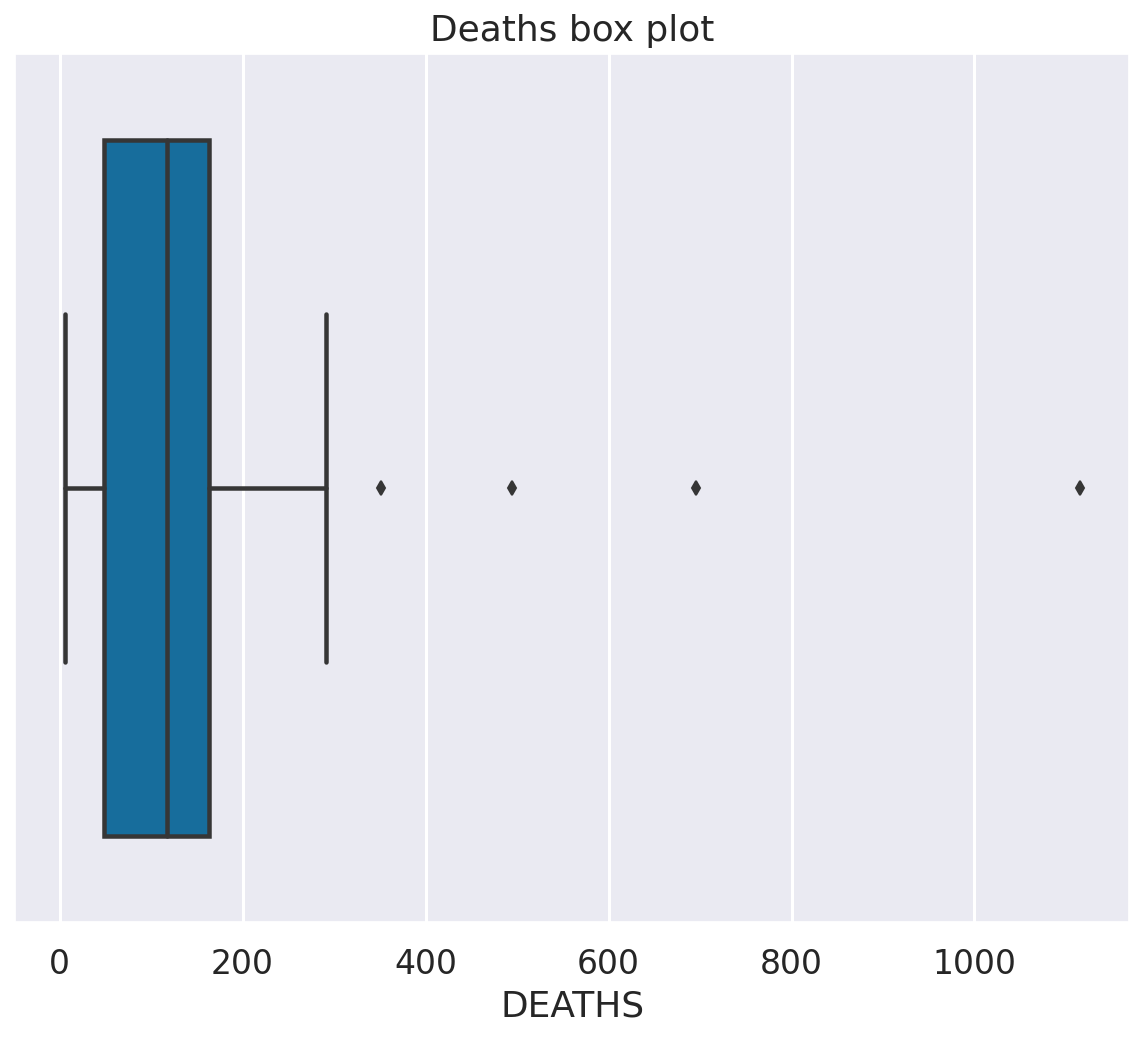

In [129]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes()

sns.boxplot(data=full_df, x="DEATHS")

plt.title("Deaths box plot")
plt.show()


### Gender analysis

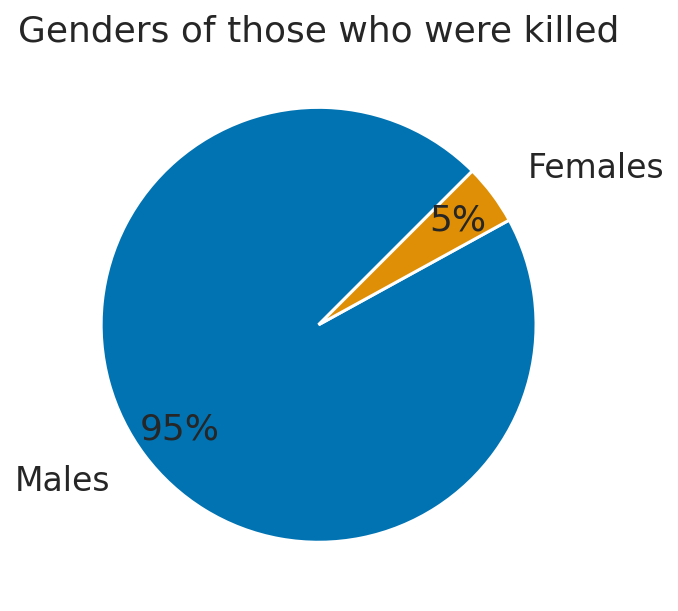

In [130]:
males_shot = len(shootings_df.loc[shootings_df["gender"].isin(["M"])])
females_shot = len(shootings_df.loc[shootings_df["gender"].isin(["F"])])
shot_arr = [males_shot, females_shot]
fig = plt.figure(figsize=(5, 5))
data = [x / len(shootings_df) for x in shot_arr]
labels = ["Males", "Females"]

plt.pie(
    data,
    labels=labels,
    autopct="%.0f%%",
    startangle=45,
    pctdistance=0.8,
    labeldistance=1.2,
)
plt.title("Genders of those who were killed")

plt.show()


## Now we know that in this dataset roughly 19 out of 20 victims are males.

Text(0.5, 1.0, 'Shooting By State: Non Gun Related')

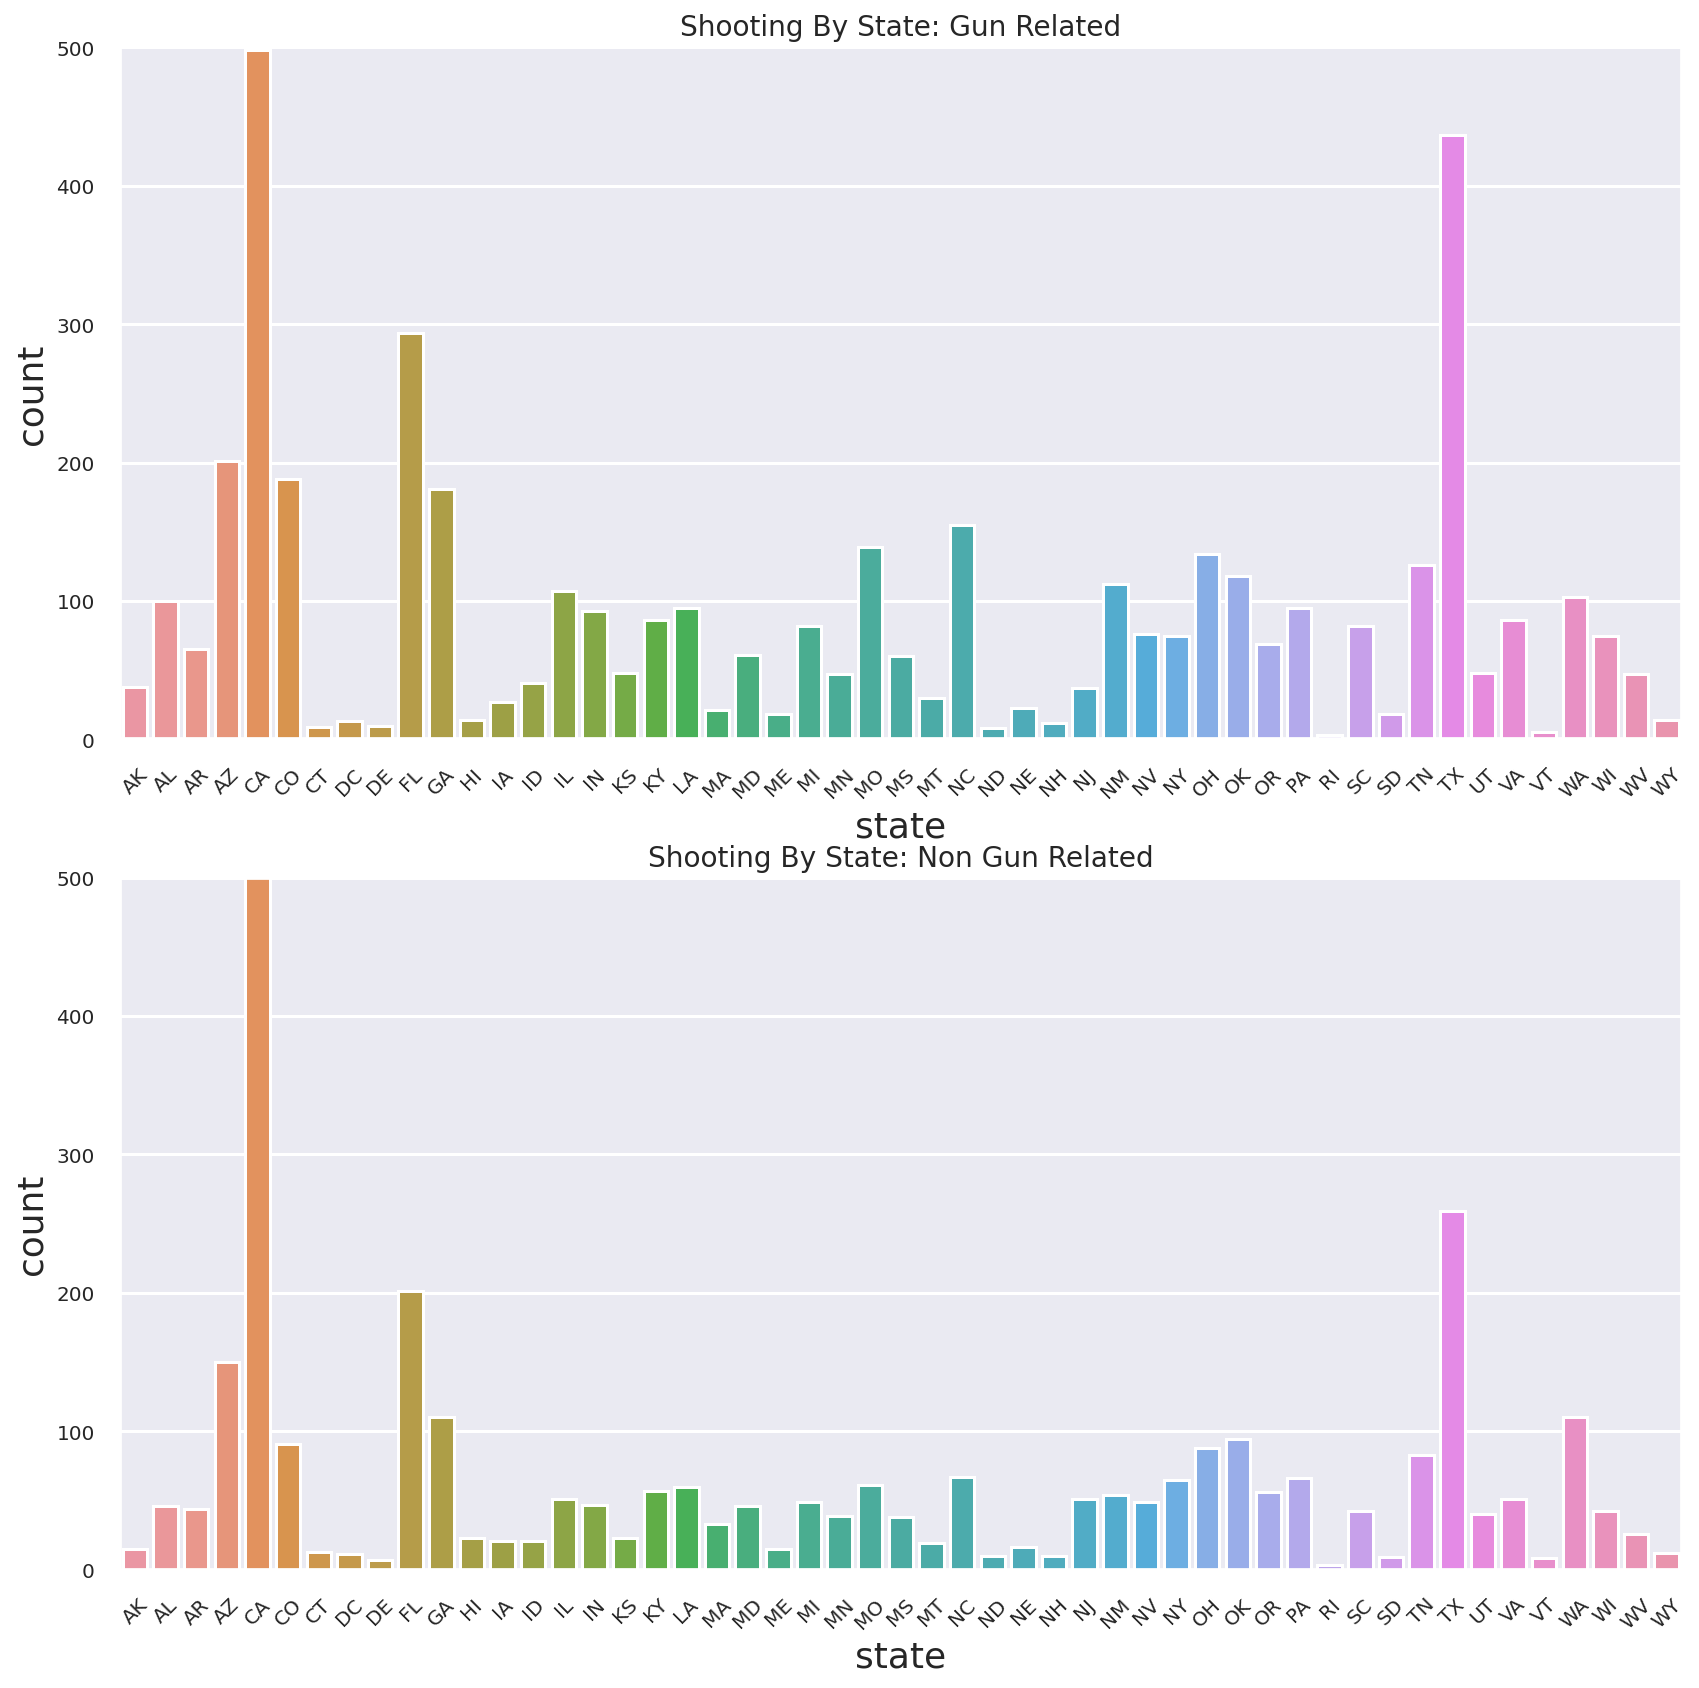

In [131]:
shootings_df.sort_values(by=["state"], inplace=True)
gun_related = shootings_df[shootings_df.armed.str.contains("gun") == True]
nongun_related = shootings_df[shootings_df.armed.str.contains("gun") != True]

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 14))

sns.countplot(data=gun_related, x="state", ax=ax1)
sns.countplot(data=nongun_related, x="state", ax=ax2)

ax1.tick_params(axis="both", which="major", labelsize=10)
ax2.tick_params(axis="both", which="major", labelsize=10)

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
ax1.set_ylim([0, 500])
ax2.set_ylim([0, 500])

ax1.set_title("Shooting by State: Gun Related".title(), fontsize=14)
ax2.set_title("Shooting by State: Non Gun Related".title(), fontsize=14)


(0.0, 100.0)

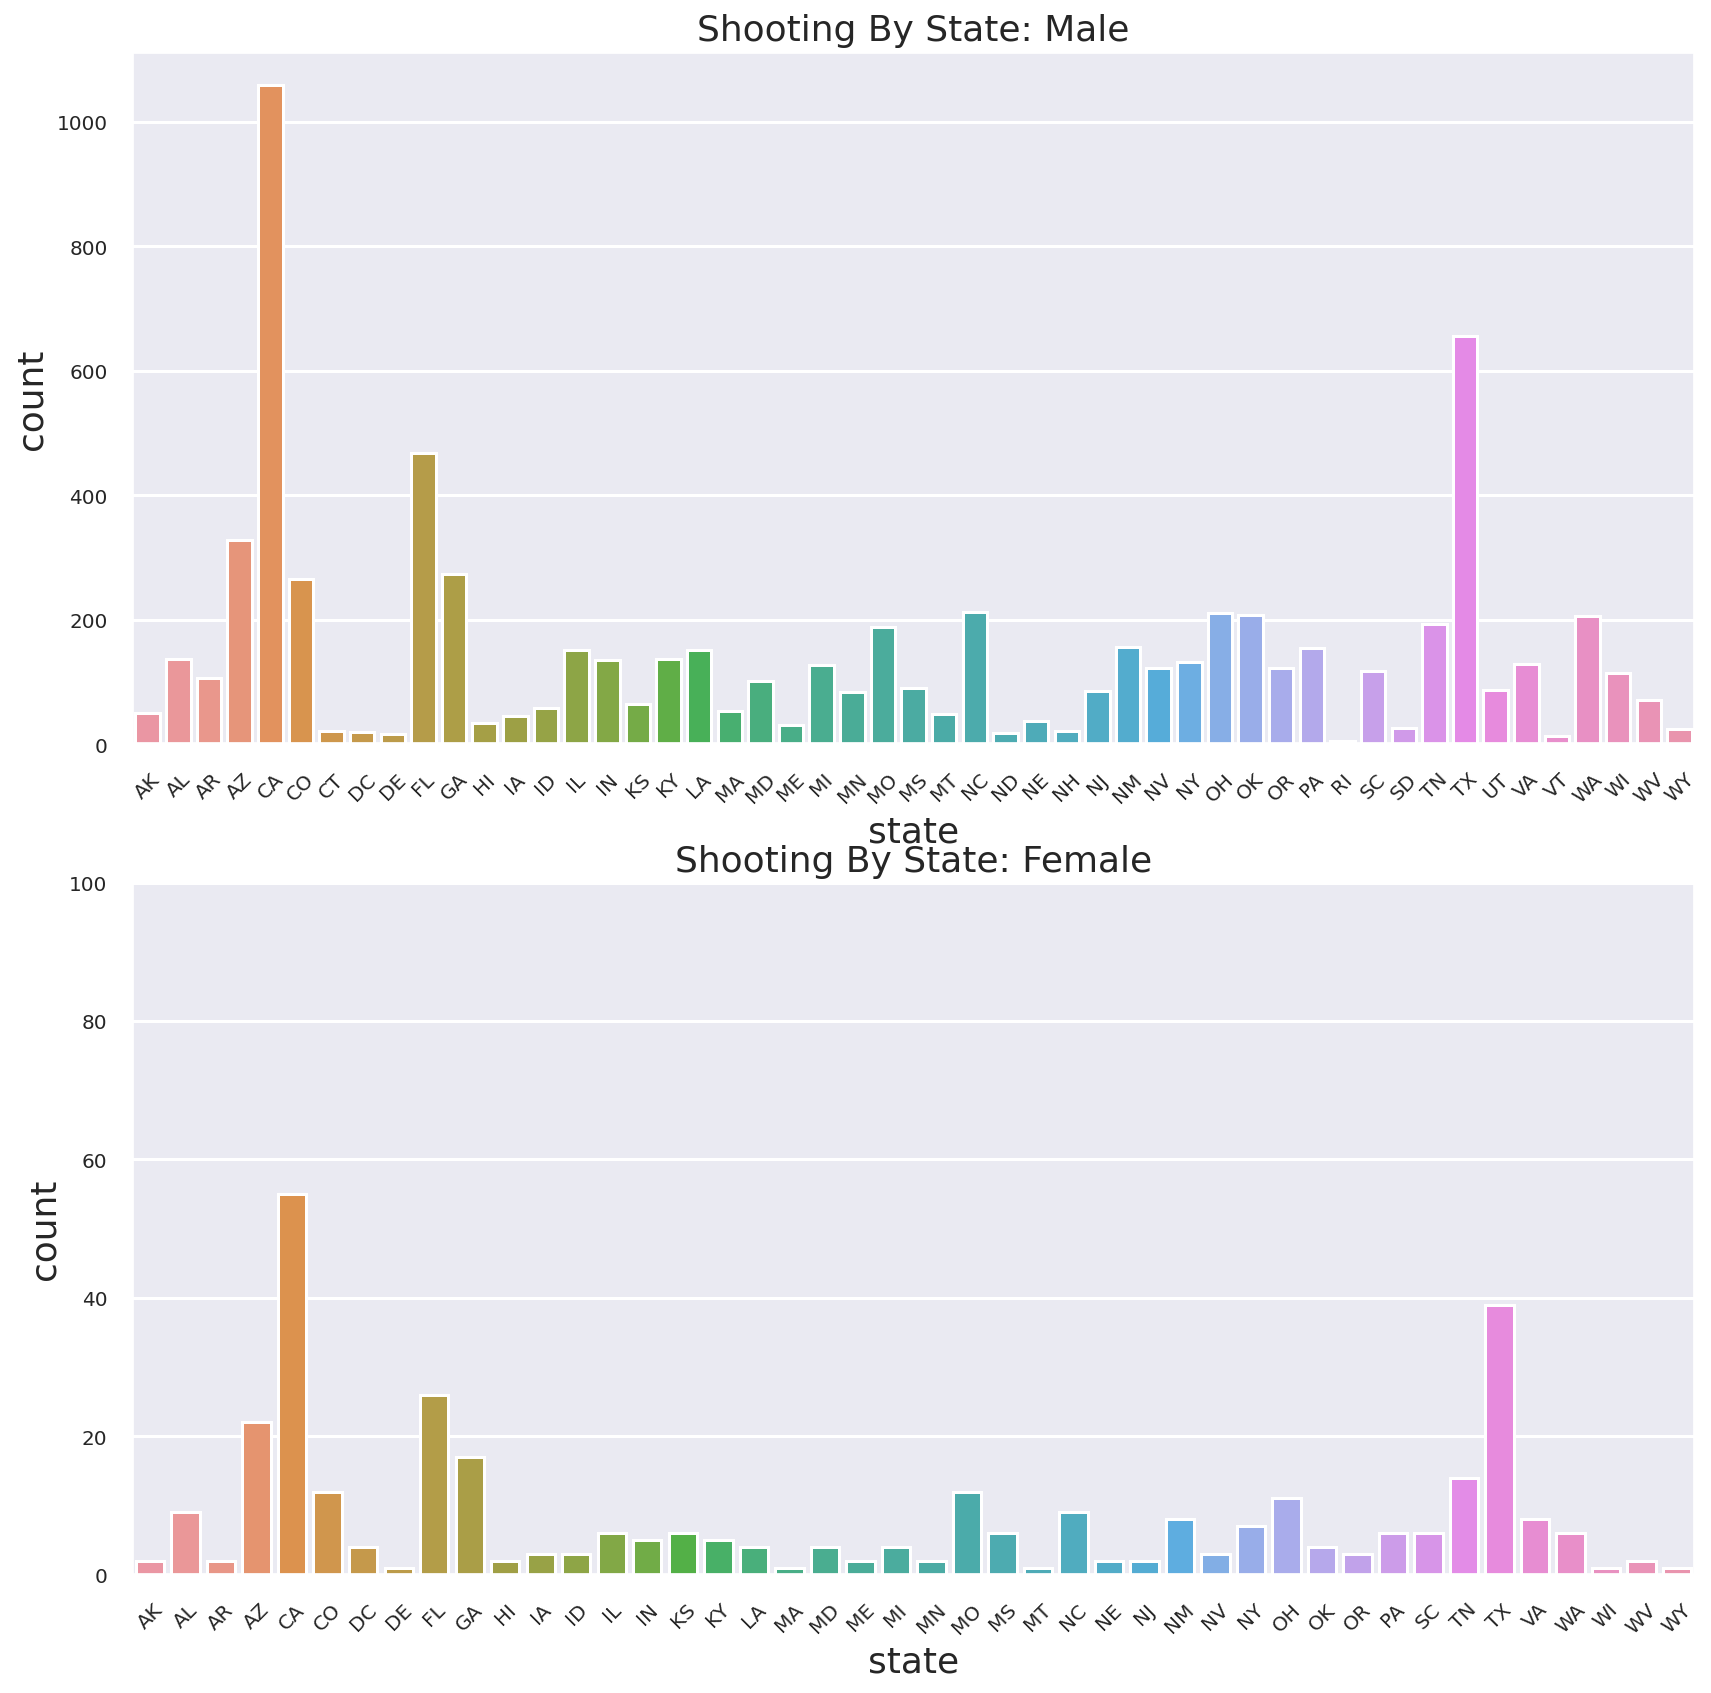

In [132]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 14))

sns.countplot(data=shootings_df.query("gender == 'M'"), x="state", ax=ax1)
sns.countplot(data=shootings_df.query("gender == 'F'"), x="state", ax=ax2)

ax1.tick_params(axis="both", which="major", labelsize=10)
ax2.tick_params(axis="both", which="major", labelsize=10)

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

ax1.set_title("Shooting by State: Male".title())
ax2.set_title("Shooting by State: Female".title())
ax2.set_ylim([0, 100])


Text(0.5, 1.0, 'Shooting By Race: Female')

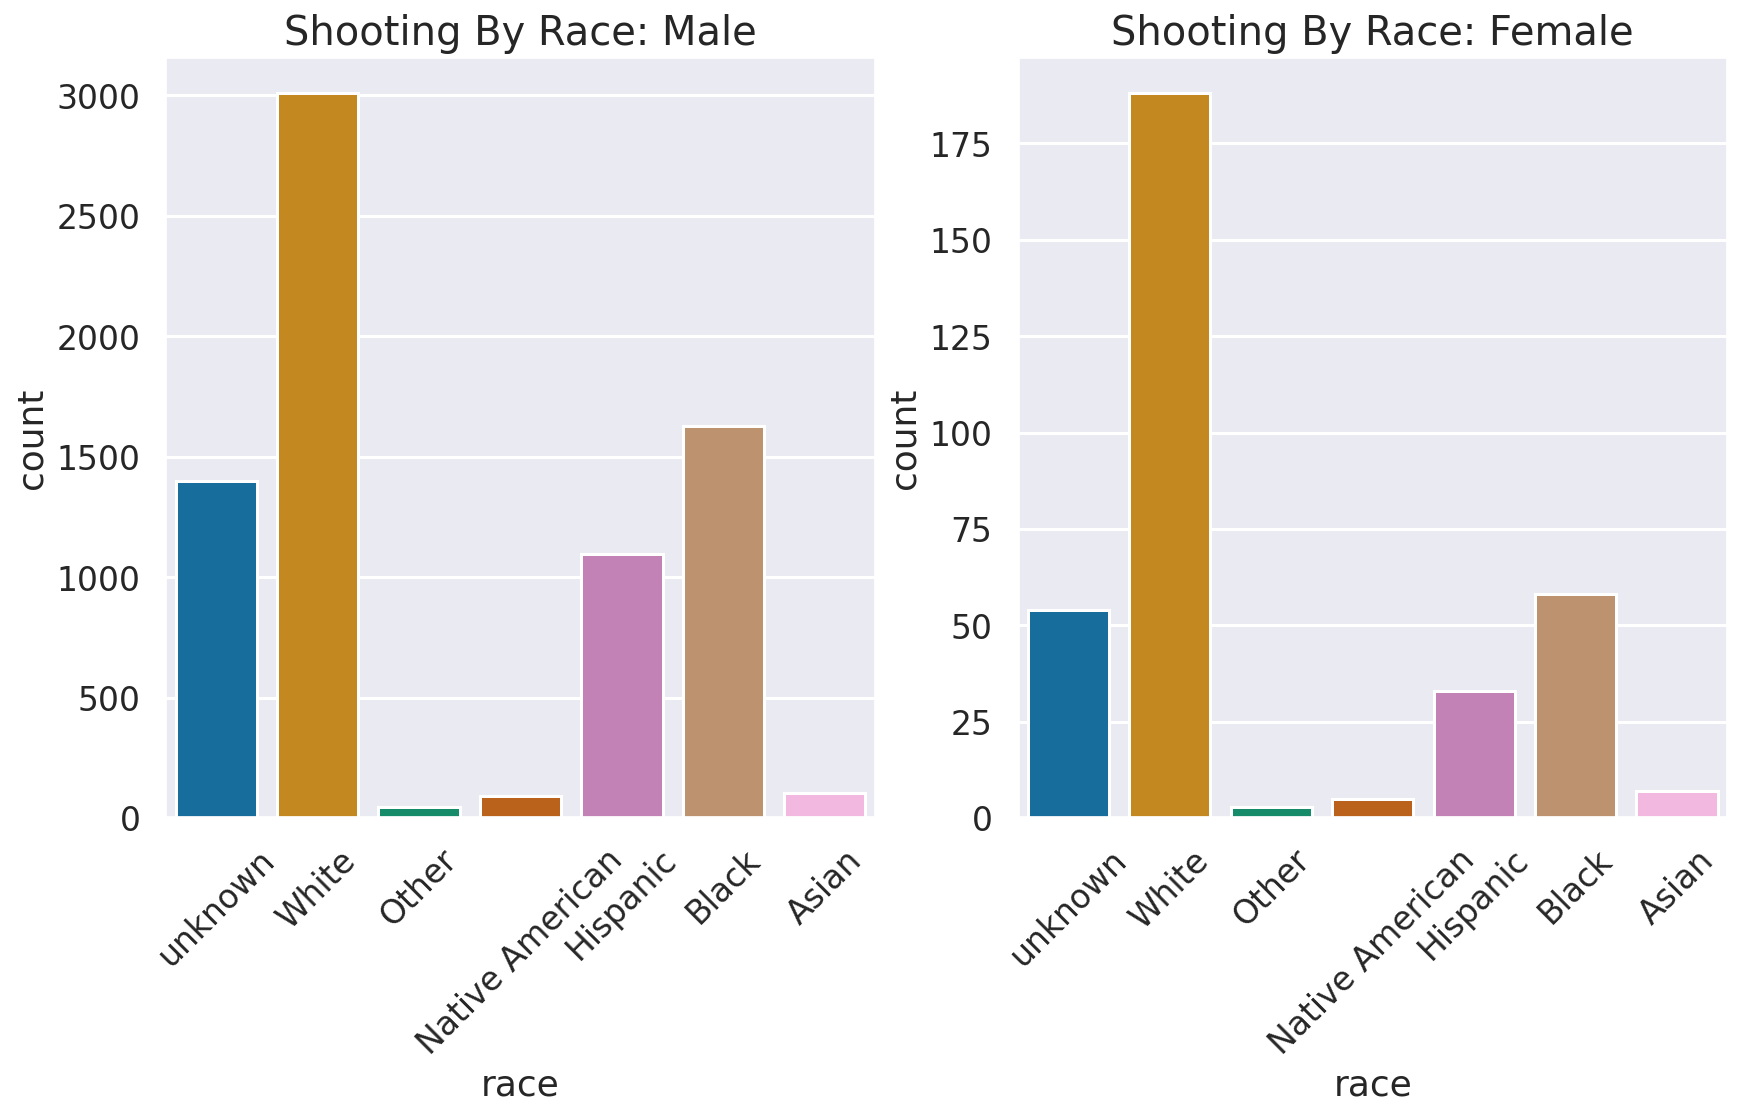

In [133]:
shootings_df.sort_values(by=["race"], inplace=True, ascending=False)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

sns.countplot(data=shootings_df.query("gender == 'M'"), x="race", ax=ax1)
sns.countplot(data=shootings_df.query("gender == 'F'"), x="race", ax=ax2)

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

ax1.set_title("Shooting by Race: Male".title(), fontsize=20)
ax2.set_title("Shooting by Race: Female".title(), fontsize=20)


Text(0.5, 1.0, 'Distribution Of Ages, Based On Race (Gun Related)')

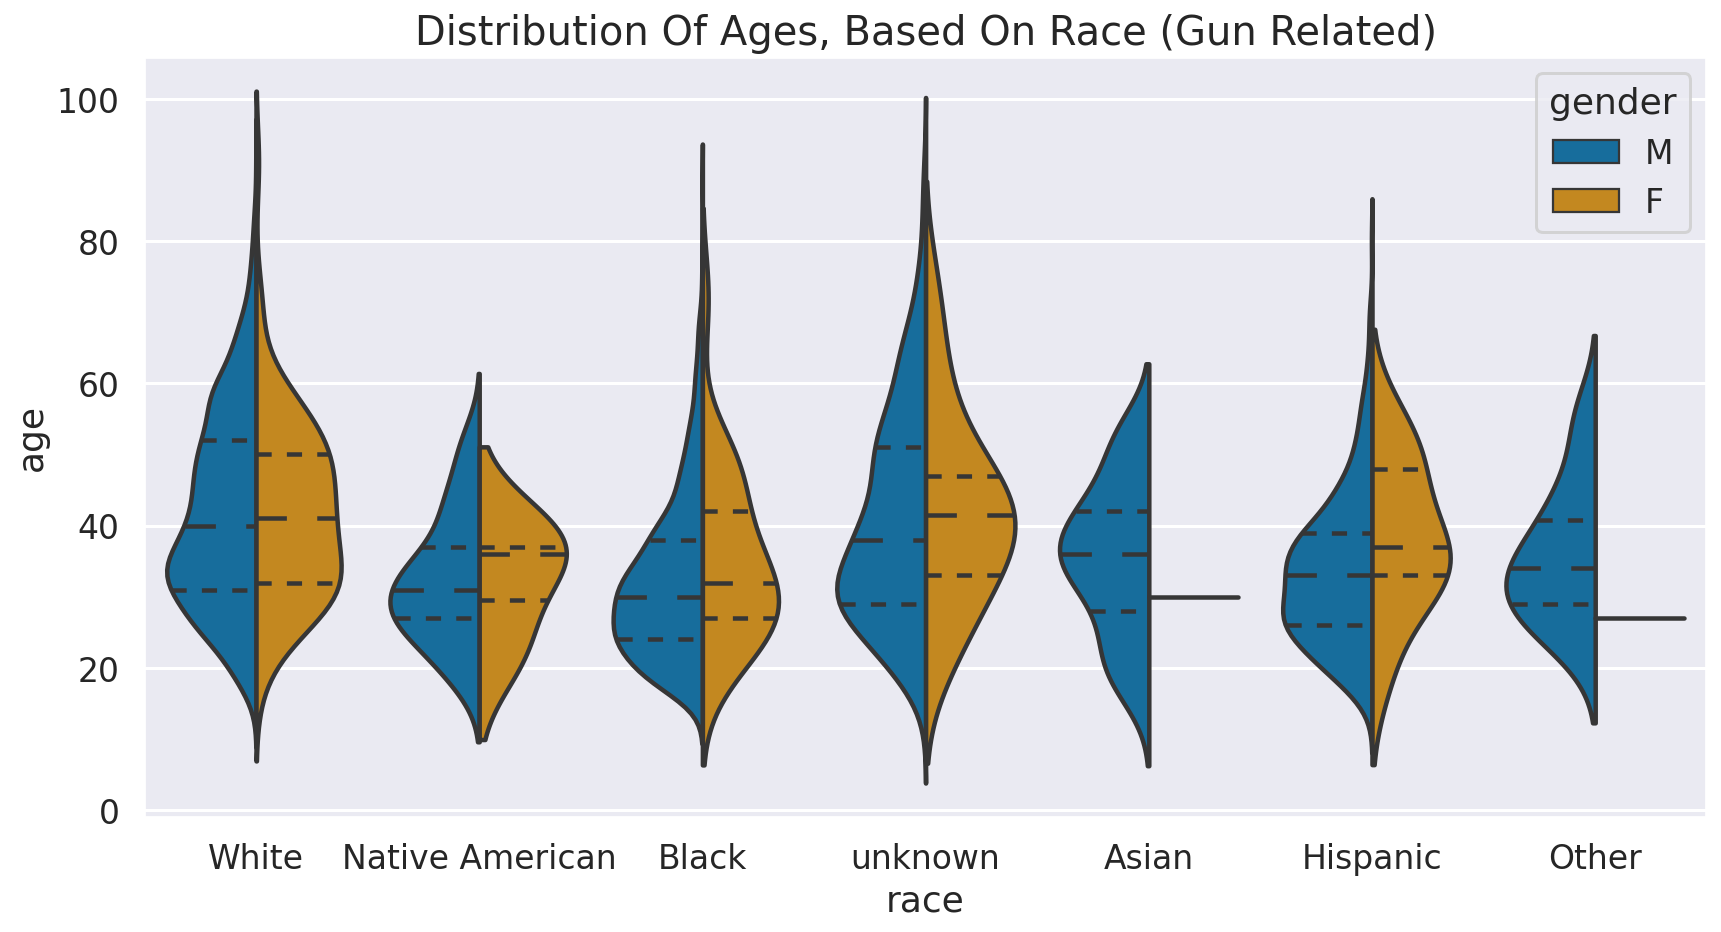

In [134]:
f, ax1 = plt.subplots(1, 1, figsize=(14, 7))
sns.violinplot(
    x="race",
    y="age",
    hue="gender",
    split=True,
    data=gun_related,
    ax=ax1,
    inner="quartile",
)

ax1.set_title("Distribution of Ages, based on race (Gun Related)".title(), fontsize=20)


Text(0.5, 1.0, 'Distribution Of Ages, Based On Race (Non Gun Related)')

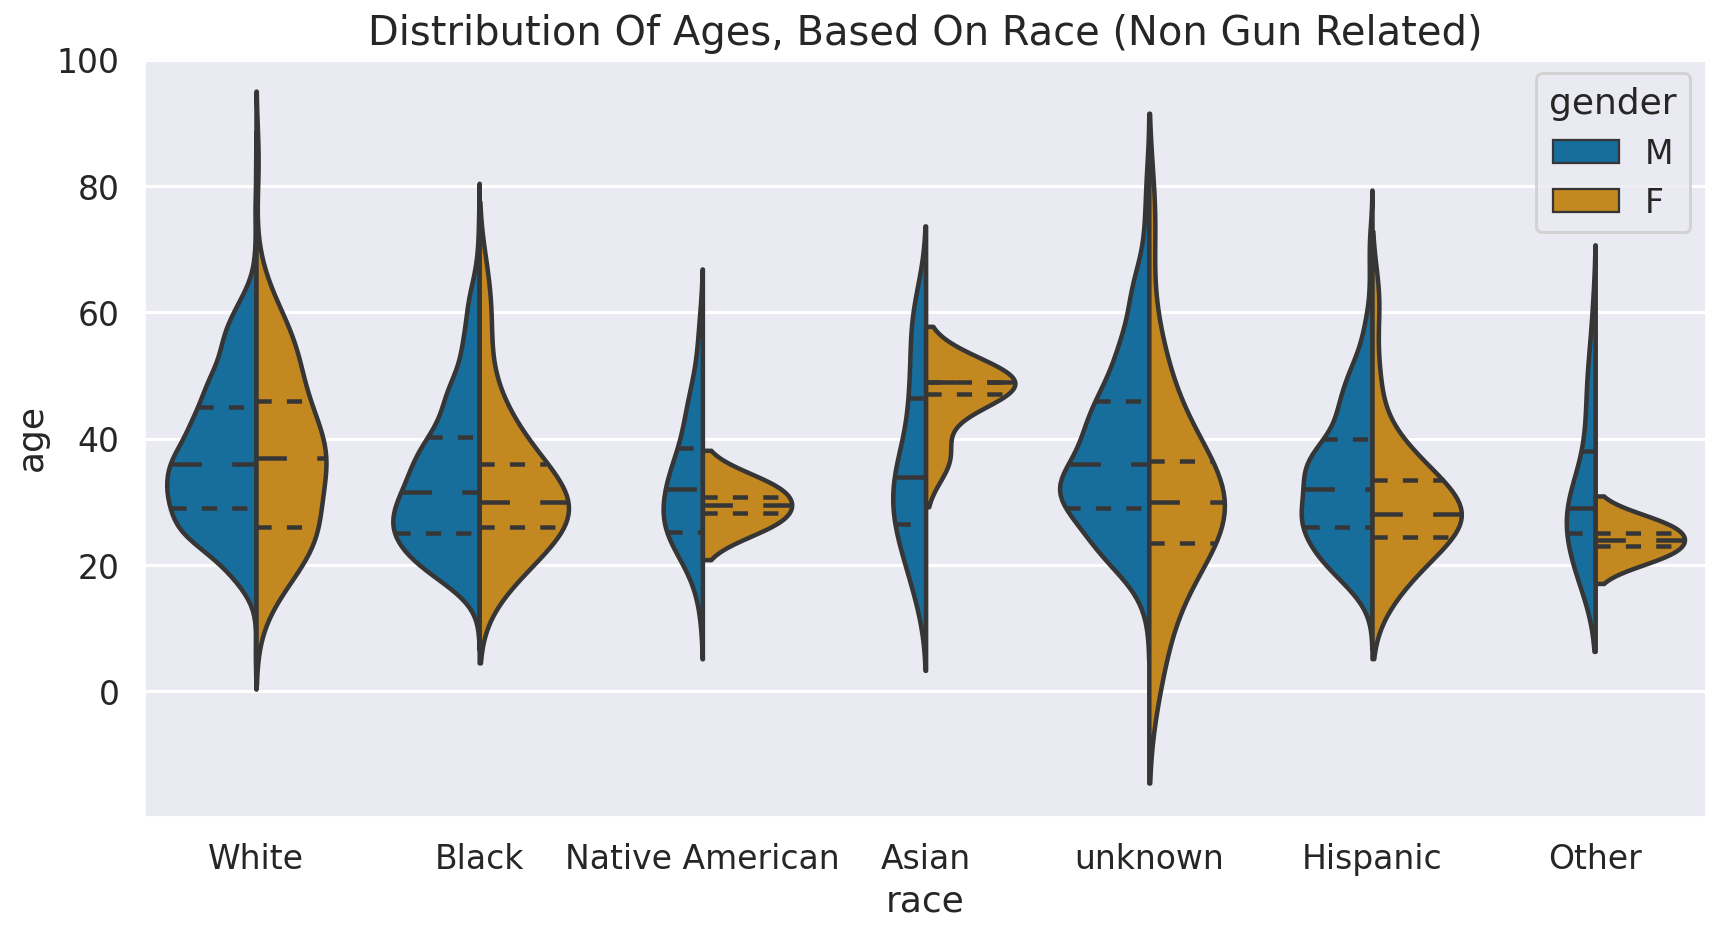

In [135]:
f, ax1 = plt.subplots(1, 1, figsize=(14, 7))
sns.violinplot(
    x="race",
    y="age",
    hue="gender",
    split=True,
    data=nongun_related,
    ax=ax1,
    inner="quartile",
)
ax1.set_title(
    "Distribution of Ages, based on race (Non Gun Related)".title(), fontsize=20
)


## What we see here is that middle aged Native American women and older age Asian women are most in danger of being shot by the police.

Text(0.5, 1.0, 'Distribution Of Ages, Based On Race (Sign Of Mental Illness)')

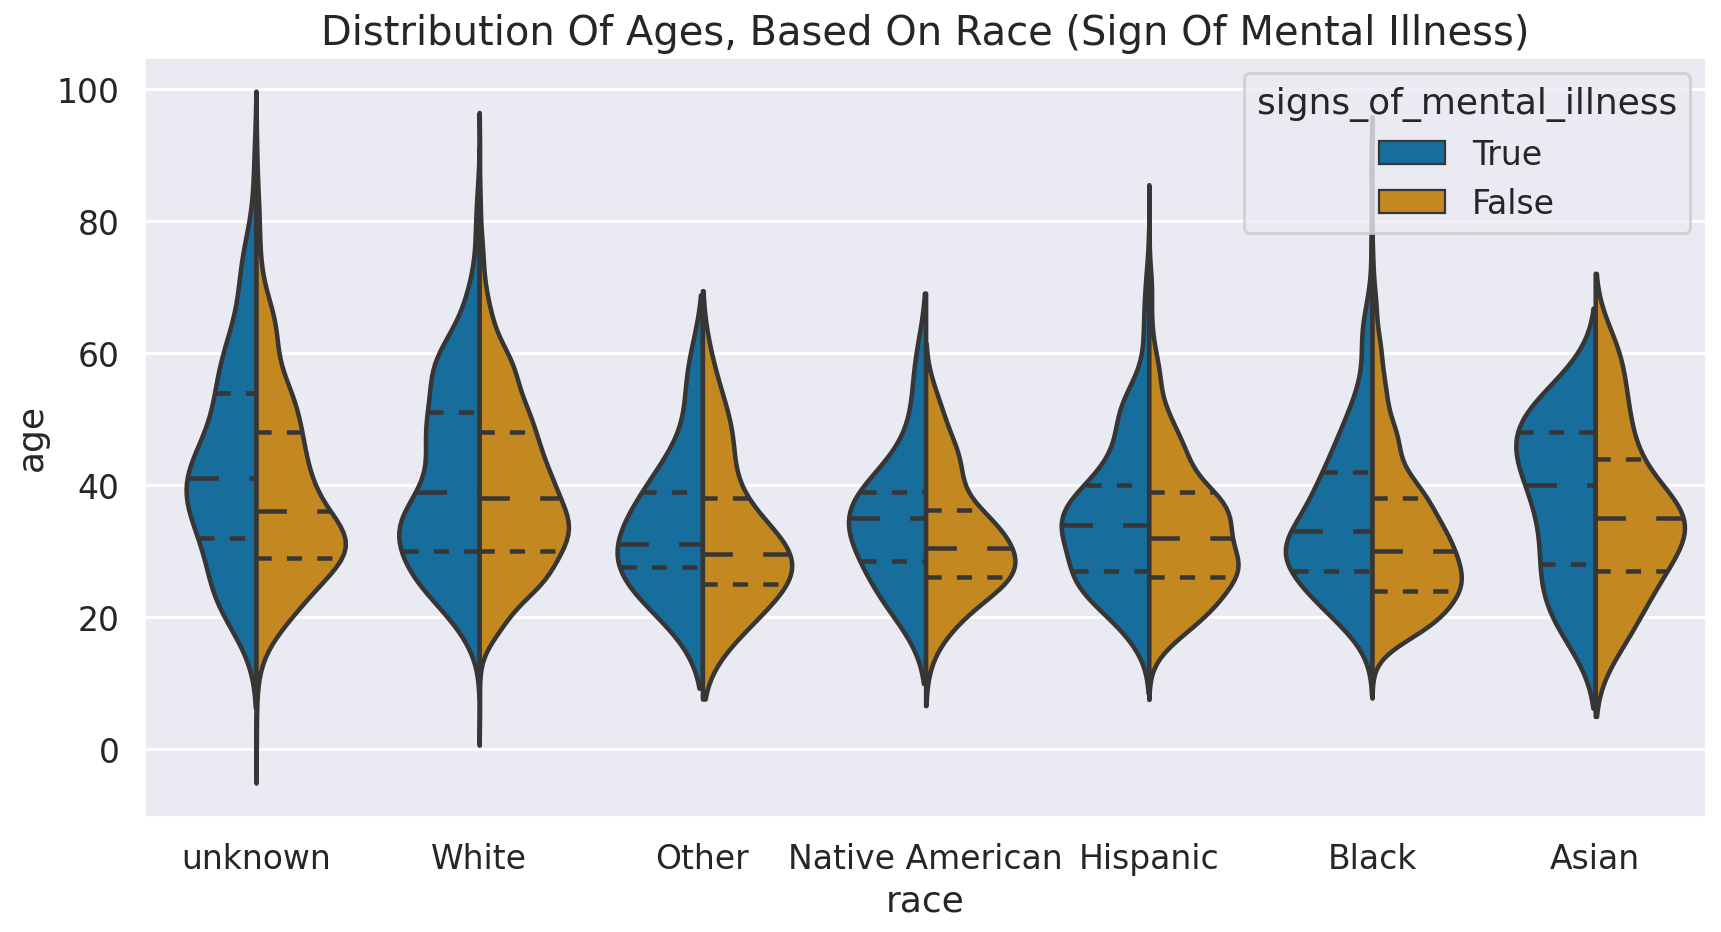

In [136]:
f, ax1 = plt.subplots(1, 1, figsize=(14, 7))
sns.violinplot(
    x="race",
    y="age",
    data=shootings_df,
    split=True,
    hue="signs_of_mental_illness",
    hue_order=[True, False],
    ax=ax1,
    inner="quartile",
)
ax1.set_title(
    "Distribution of Ages, based on race (Sign of Mental Illness)".title(), fontsize=20
)


## Age vs. Signs of Mental Illness

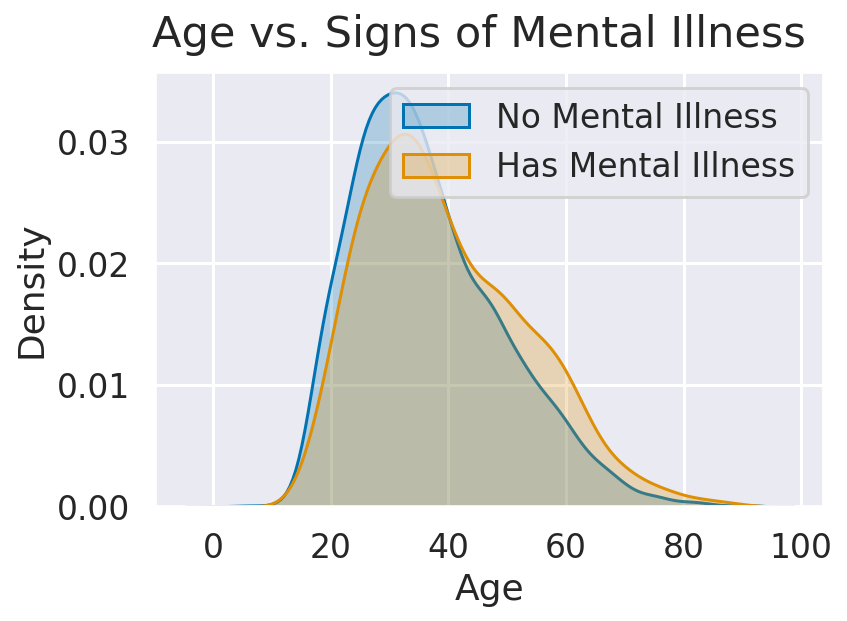

In [137]:
fig, ax = plt.subplots()

sns.kdeplot(
    shootings_df[shootings_df["signs_of_mental_illness"] == False]["age"],
    shade=True,
    label="No Mental Illness",
    ax=ax,
)
sns.kdeplot(
    shootings_df[shootings_df["signs_of_mental_illness"] == True]["age"],
    shade=True,
    label="Has Mental Illness",
    ax=ax,
)

ax.set_xlabel("Age")
ax.set_ylabel("Density")

fig.suptitle("Age vs. Signs of Mental Illness")
ax.legend()


## Gender vs. Signs of Mental Illness

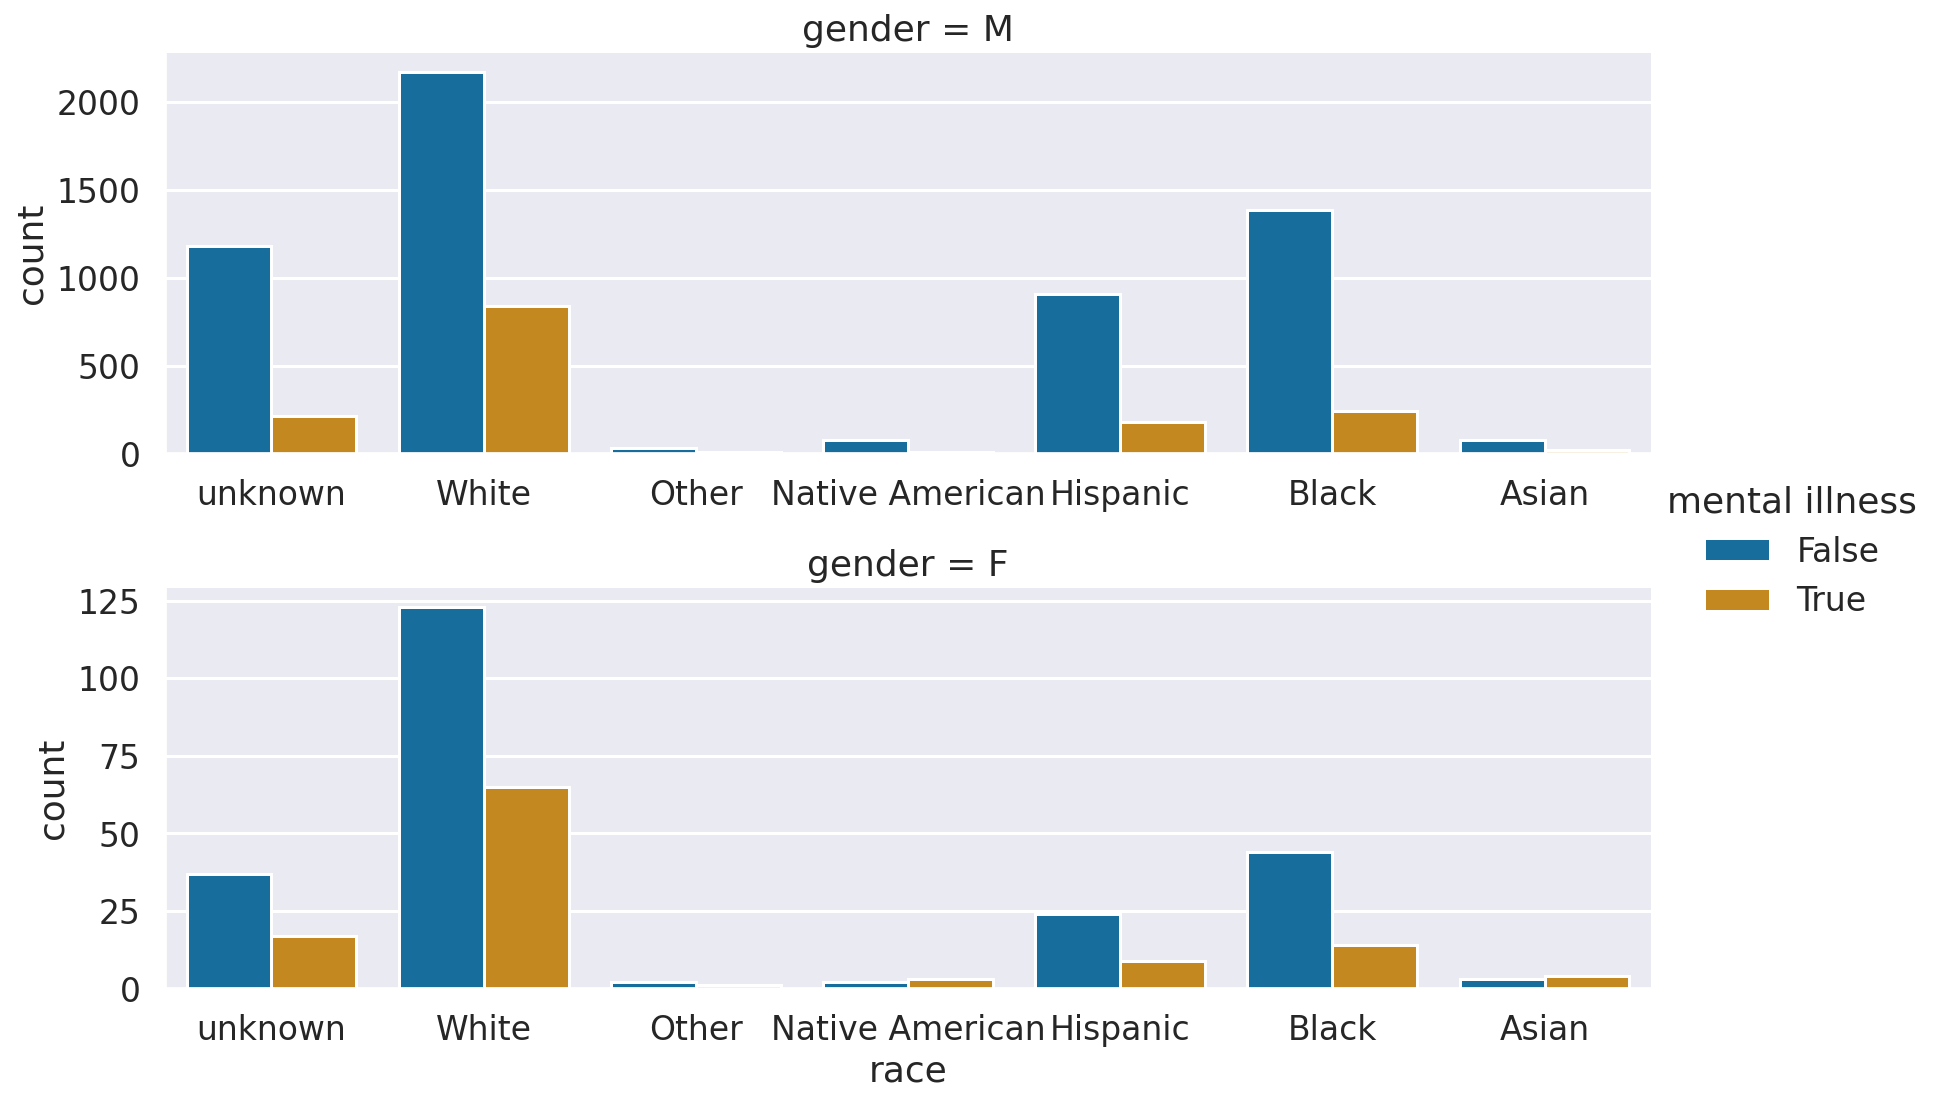

In [138]:
g = sns.FacetGrid(
    shootings_df, row="gender", height=4, aspect=3, sharex=False, sharey=False
)
g.map_dataframe(
    sns.countplot, "race", hue="signs_of_mental_illness", palette="colorblind"
)
g.add_legend(title="mental illness")
axes = g.axes.flatten()


### Race analysis

#### Box plots of age by race

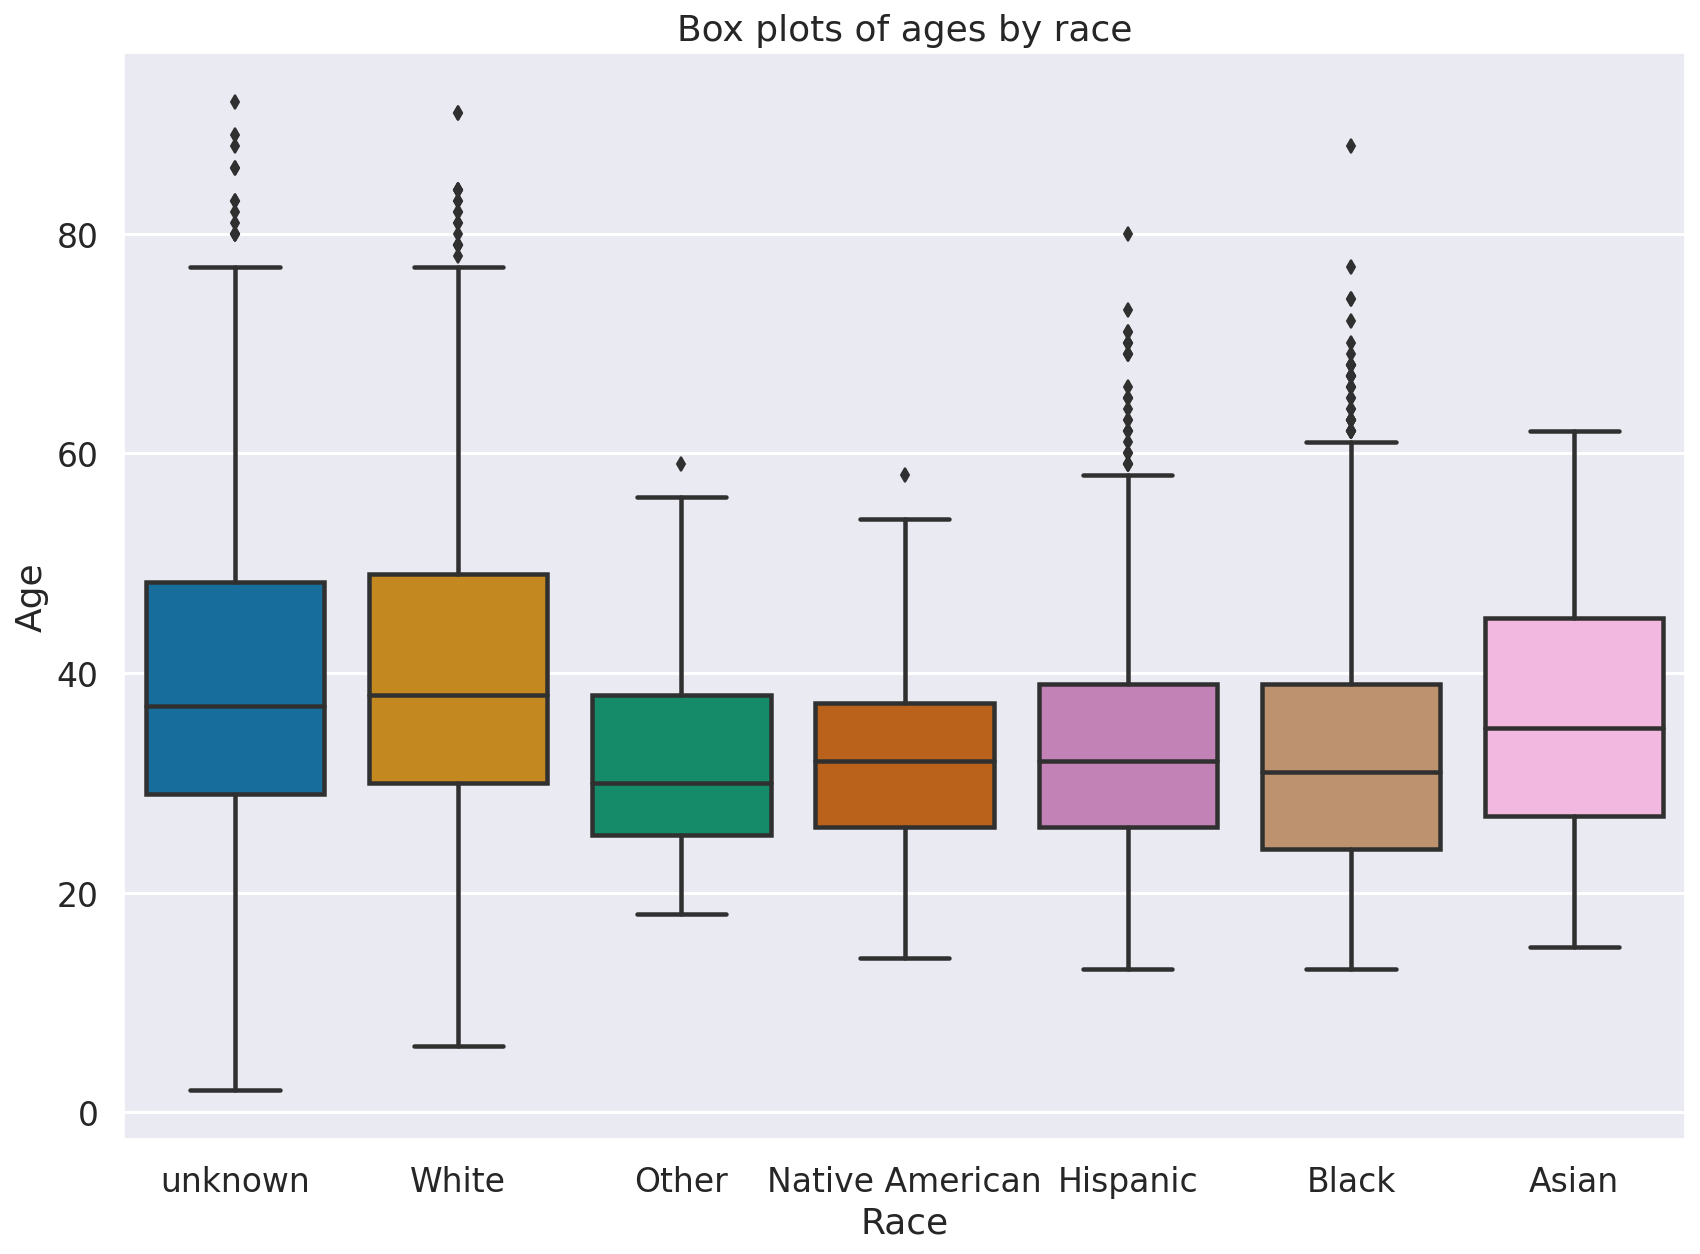

In [139]:
fig = plt.figure(figsize=(14, 10))
ax = plt.axes()

sns.boxplot(data=shootings_df, x="race", y="age")

plt.xlabel("Race")
plt.ylabel("Age")
plt.title("Box plots of ages by race")
plt.show()


From these box plots we can see that white race box is higher than other races and that would suggest that white people are usually older when they get killed.

#### White, Black, Hispanic races age comparison.

In [140]:
freq_race = shootings_df[shootings_df["race"].isin(["White", "Black", "Hispanic"])]
freq_race.groupby("race").describe().apply(lambda x: x.apply("{:n}".format))["age"]


,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
Black,1650,32.8673,11.3867,13,24,31,39,88
Hispanic,1097,33.6135,10.7582,13,26,32,39,80
White,3147,40.0588,13.122,6,30,38,49,91


I decided to take a look at 3 most frequent races in this dataset and found out that black and hispanic people who get killed on average are 5-7 years younger than white people. It is important to mention that hispanic and black people are minorities in USA. There are twice as much white people than these two races/ethnic groups combined.

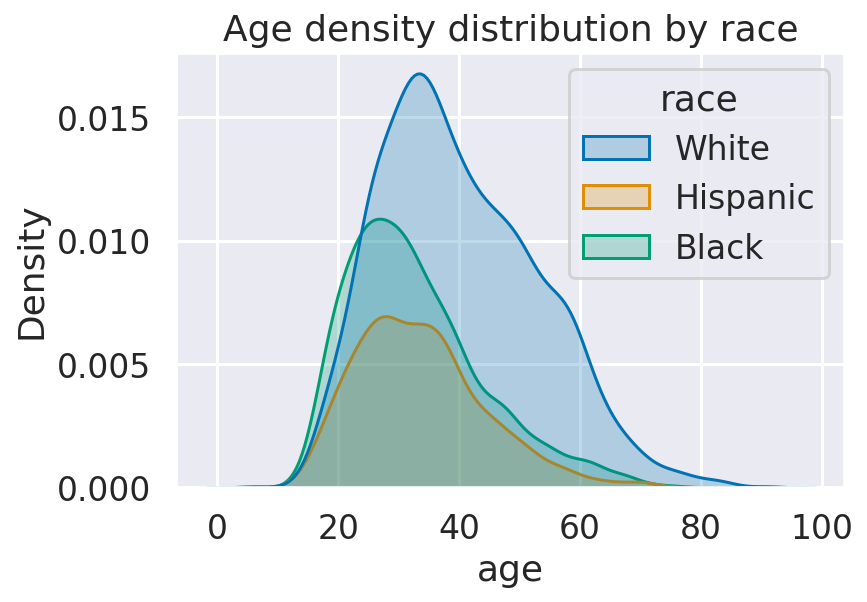

In [141]:
fig = plt.figure()
sns.kdeplot(data=freq_race, x="age", hue="race", shade=True)
plt.title("Age density distribution by race")
plt.show()


## This density distribution plot shows that even though white people have twice as much deaths as black people, black people have more deaths at around age 25.

#### Races pie chart

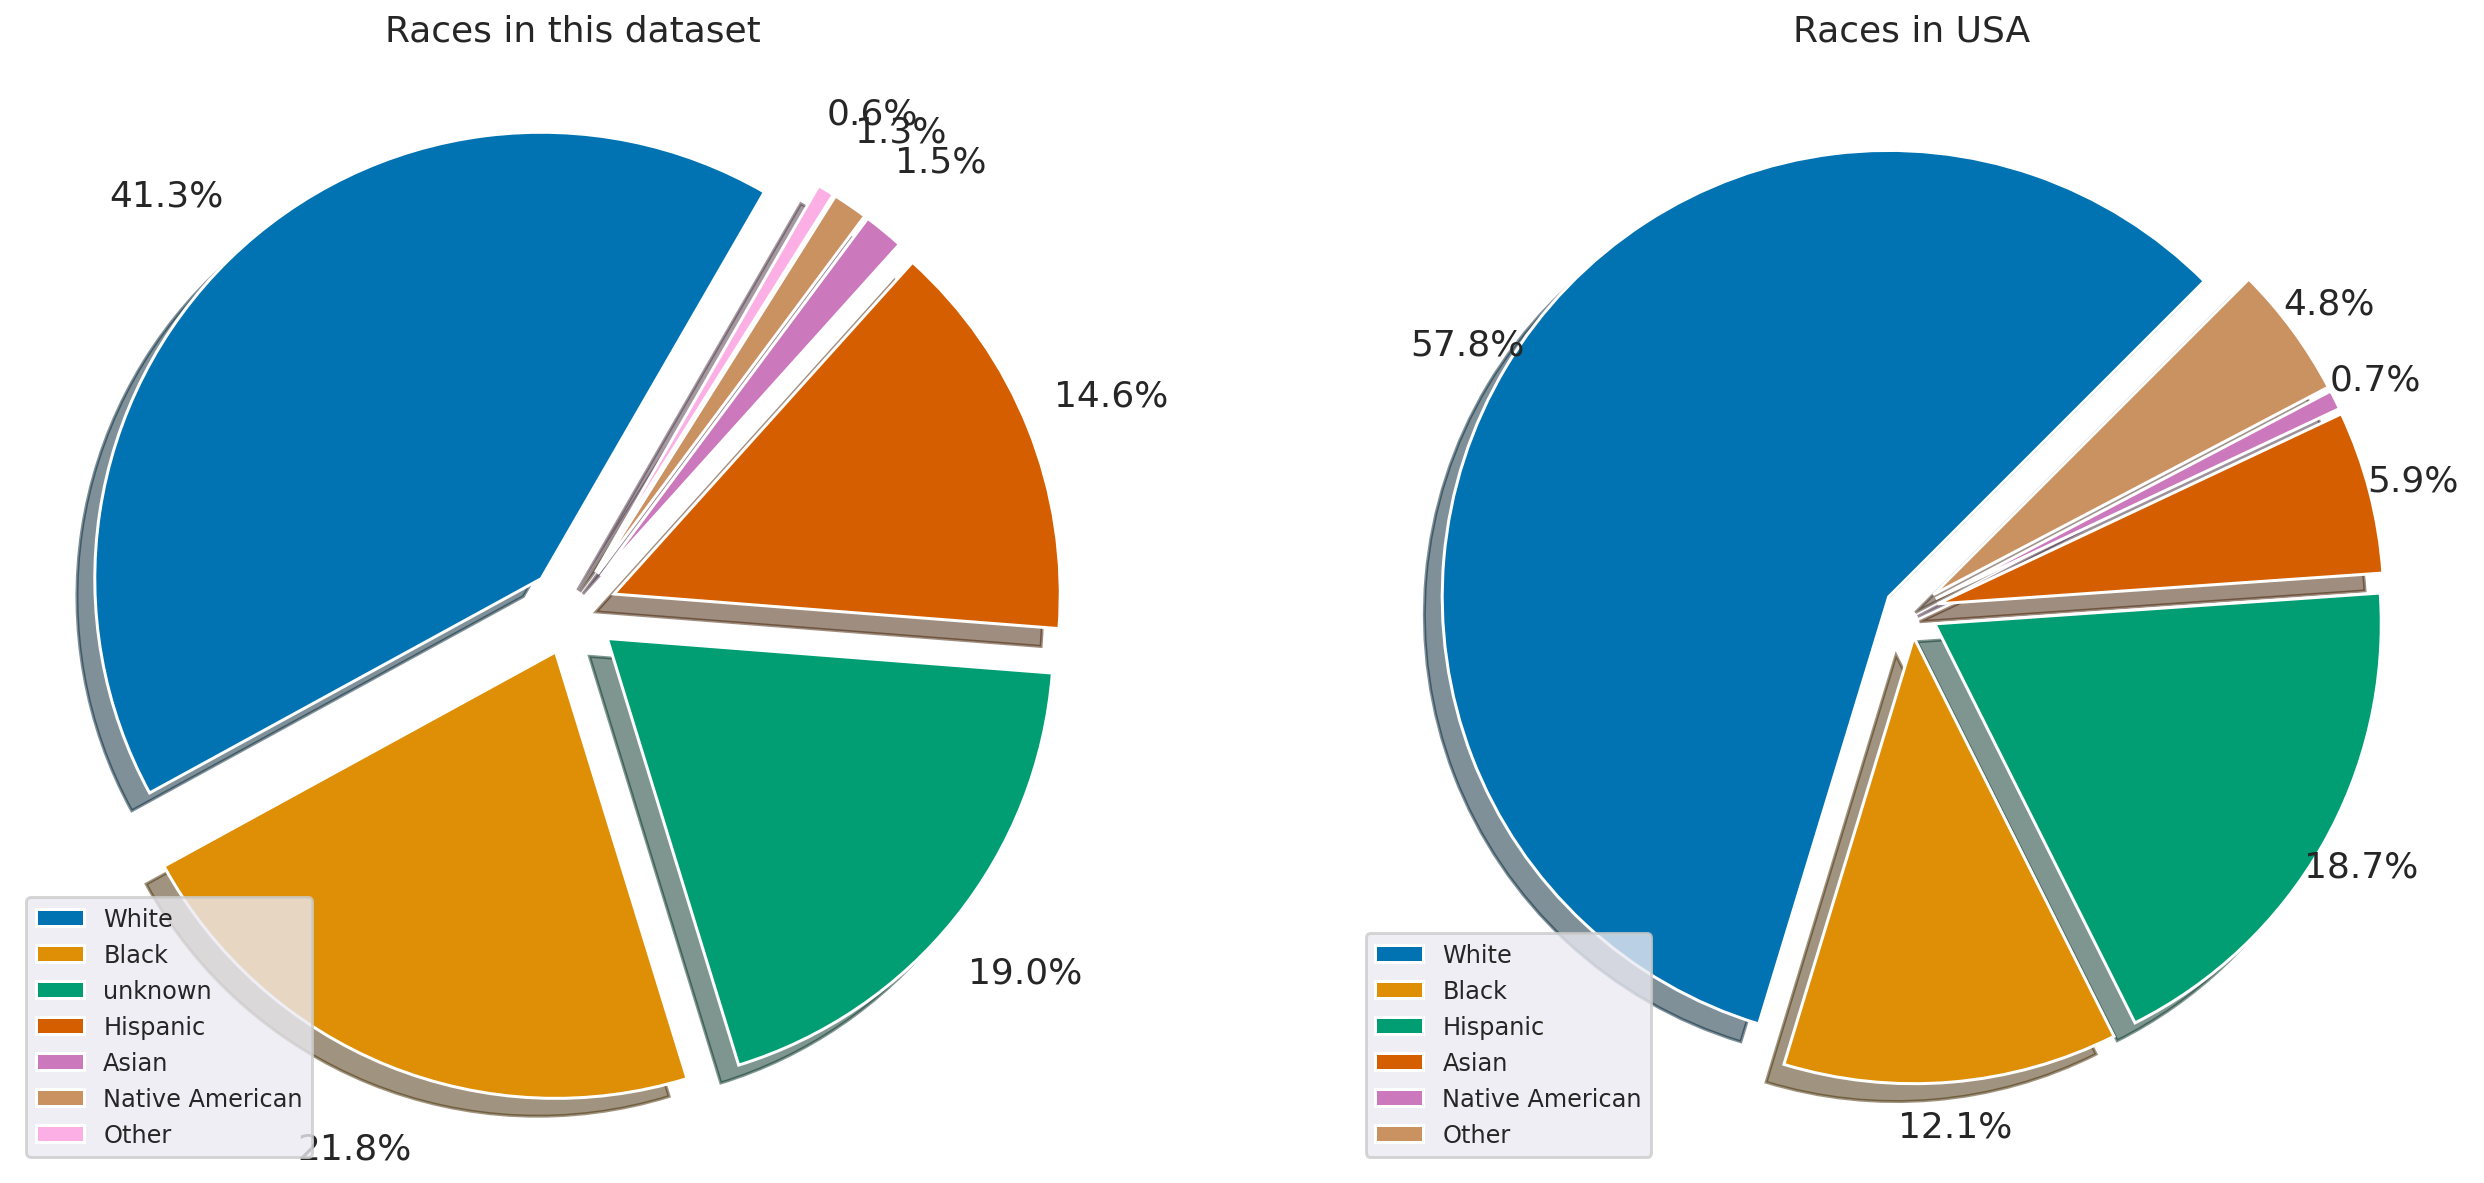

In [142]:
total_pop = full_df["POPULATION"].sum()
race_pop = {
    "White": int(total_pop * 0.578),
    "Black": int(total_pop * 0.121),
    "Hispanic": int(total_pop * 0.187),
    "Asian": int(total_pop * 0.059),
    "Native American": int(total_pop * 0.007),
    "Other": int(total_pop * 0.048),
}
race_pop_s = pd.Series(data=race_pop)
by_race = shootings_df["race"].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 22))

labels = by_race.index

ax1.pie(
    by_race,
    autopct="%.1f%%",
    startangle=60,
    labeldistance=1,
    explode=[0.1] * len(by_race),
    pctdistance=1.2,
    shadow=True,
)

ax1.title.set_text("Races in this dataset")
ax1.legend(labels, loc="lower left", prop={"size": 12})

labels = race_pop_s.index

ax2.pie(
    race_pop_s,
    autopct="%.1f%%",
    startangle=45,
    labeldistance=0.5,
    explode=[0.06] * len(race_pop_s),
    pctdistance=1.1,
    shadow=True,
)

ax2.legend(labels, loc="lower left", prop={"size": 12})
ax2.title.set_text("Races in USA")

plt.show()


In the left pie chart we can see that ~41% people were of white race, followed up by black and hispanic races and only a minor amount of people were native american/asian or of other races. In the right pie chart we see race percentages in USA. In a world where all races are equal in every term these percentages should be close to each other. The problem is the percentage of black people getting killed by police vs the percentage of black people in USA. Also white people get killed less frequently compared to percentage of them living in USA. This might suggest that police is biased against black people and have a bias in favour of white people.

In [143]:
white_race = shootings_df["race"].isin(["White"]).sum()
black_race = shootings_df["race"].isin(["Black"]).sum()
print(f'1 in {int(race_pop.get("White")/white_race)} white people get killed by police')
print(f'1 in {int(race_pop.get("Black")/black_race)} black people get killed by police')
print(
    f'{((race_pop.get("White")/white_race)/(race_pop.get("Black")/black_race)).round(2)} ' +
    'times more often black people get killed by police compared to white people'
)


1 in 60722 white people get killed by police
1 in 24097 black people get killed by police
2.52 times more often black people get killed by police compared to white people


## As we can see it is a clear that black people get killed 2.52 times more often compared to white people.

#### Threat level by race

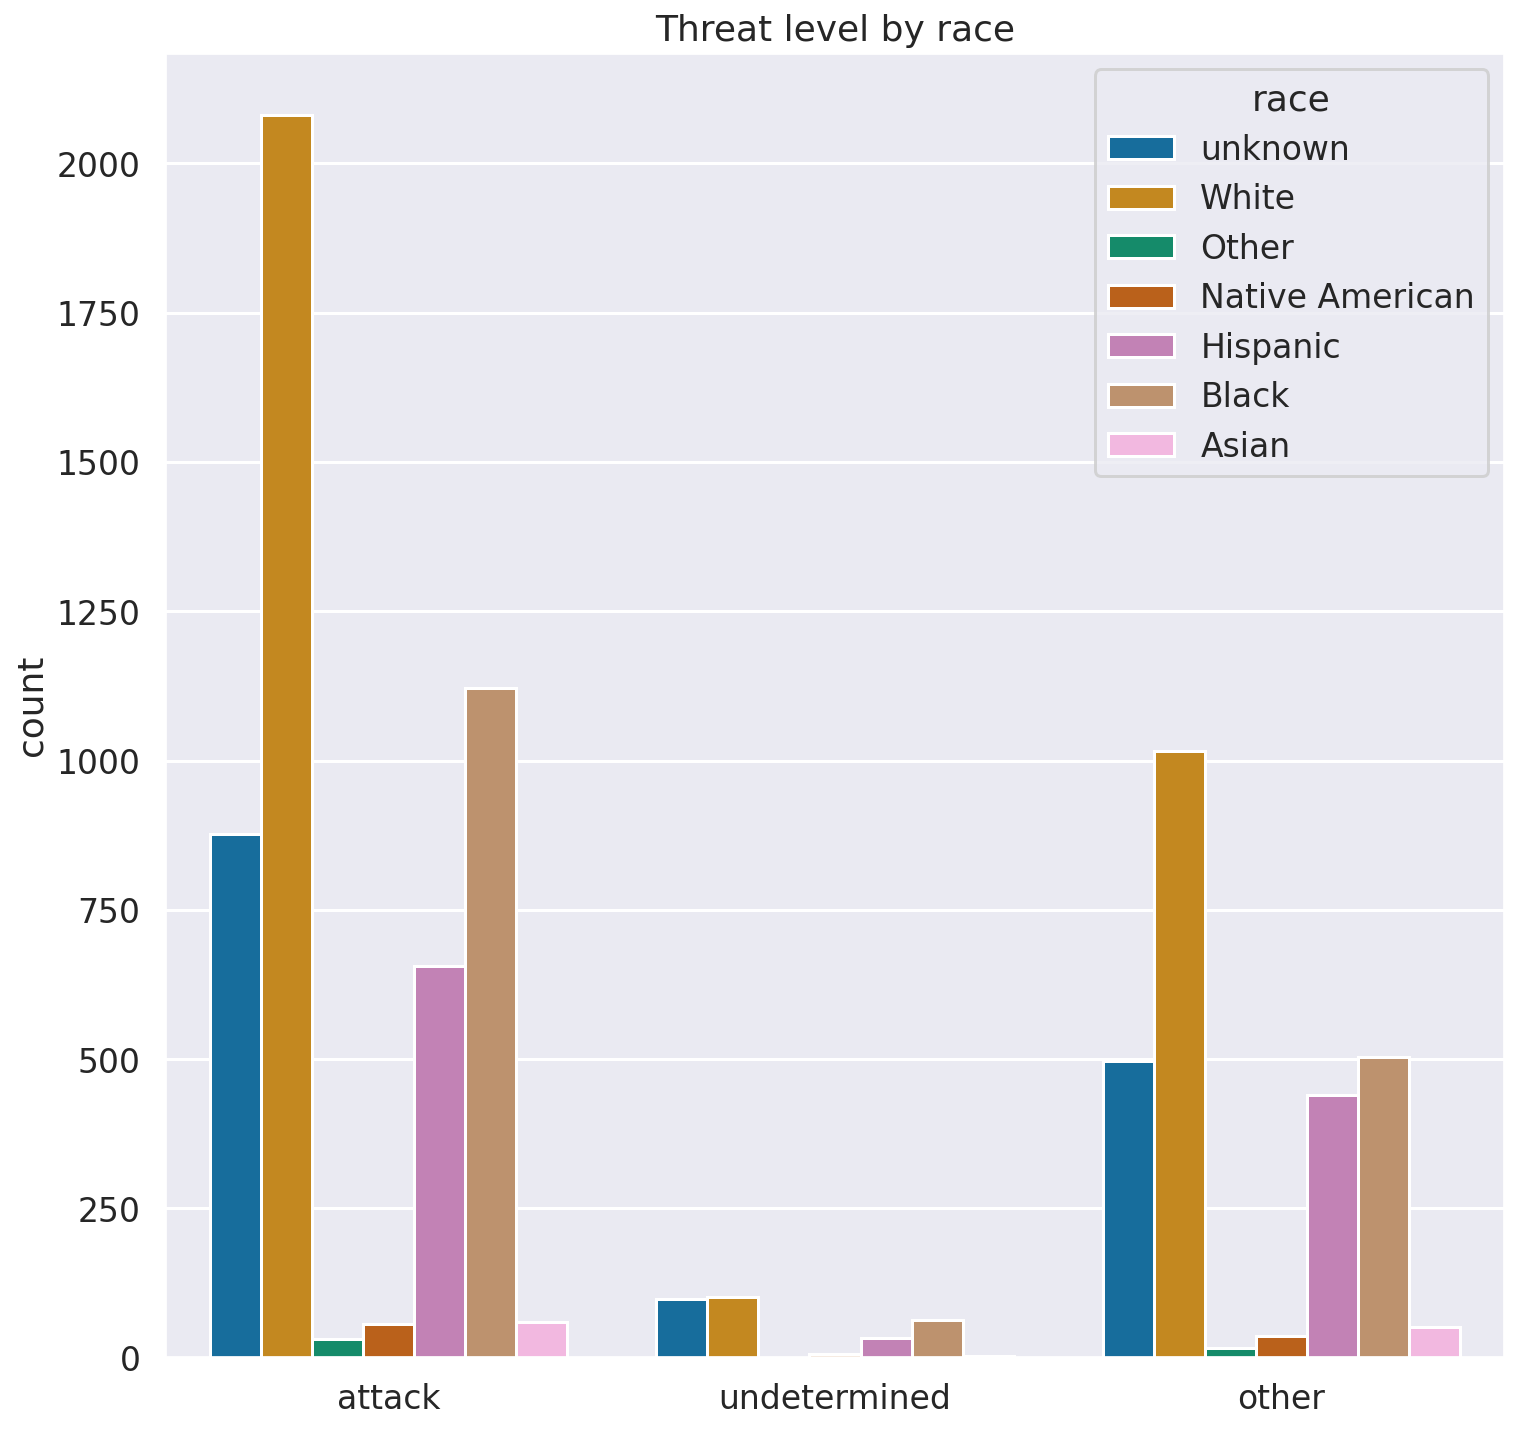

In [144]:
fig = plt.figure(figsize=(12, 12))

sns.countplot(x=shootings_df["threat_level"], hue=shootings_df["race"])

plt.title("Threat level by race")
plt.xlabel("")
plt.show()


In [145]:
shootings_df["threat_level"].value_counts(normalize=True)


attack          0.630376
other           0.330492
undetermined    0.039132
Name: threat_level, dtype: float64

The general criterion for the attack label is clear and present threat to life. This would include incidents where officers or others were shot, threatened with a firearm, attacked with a weapon or other force. The "Atttack" category is a flag of the highest level of threat. "Other" and "Undetermined" categories represent all remaining cases. The "Other" category includes many incidents in which officers or others have been faced with a significant threats. 

## About 63% of people in this dataset who died has been attacking police officers.

#### Manner of death by race

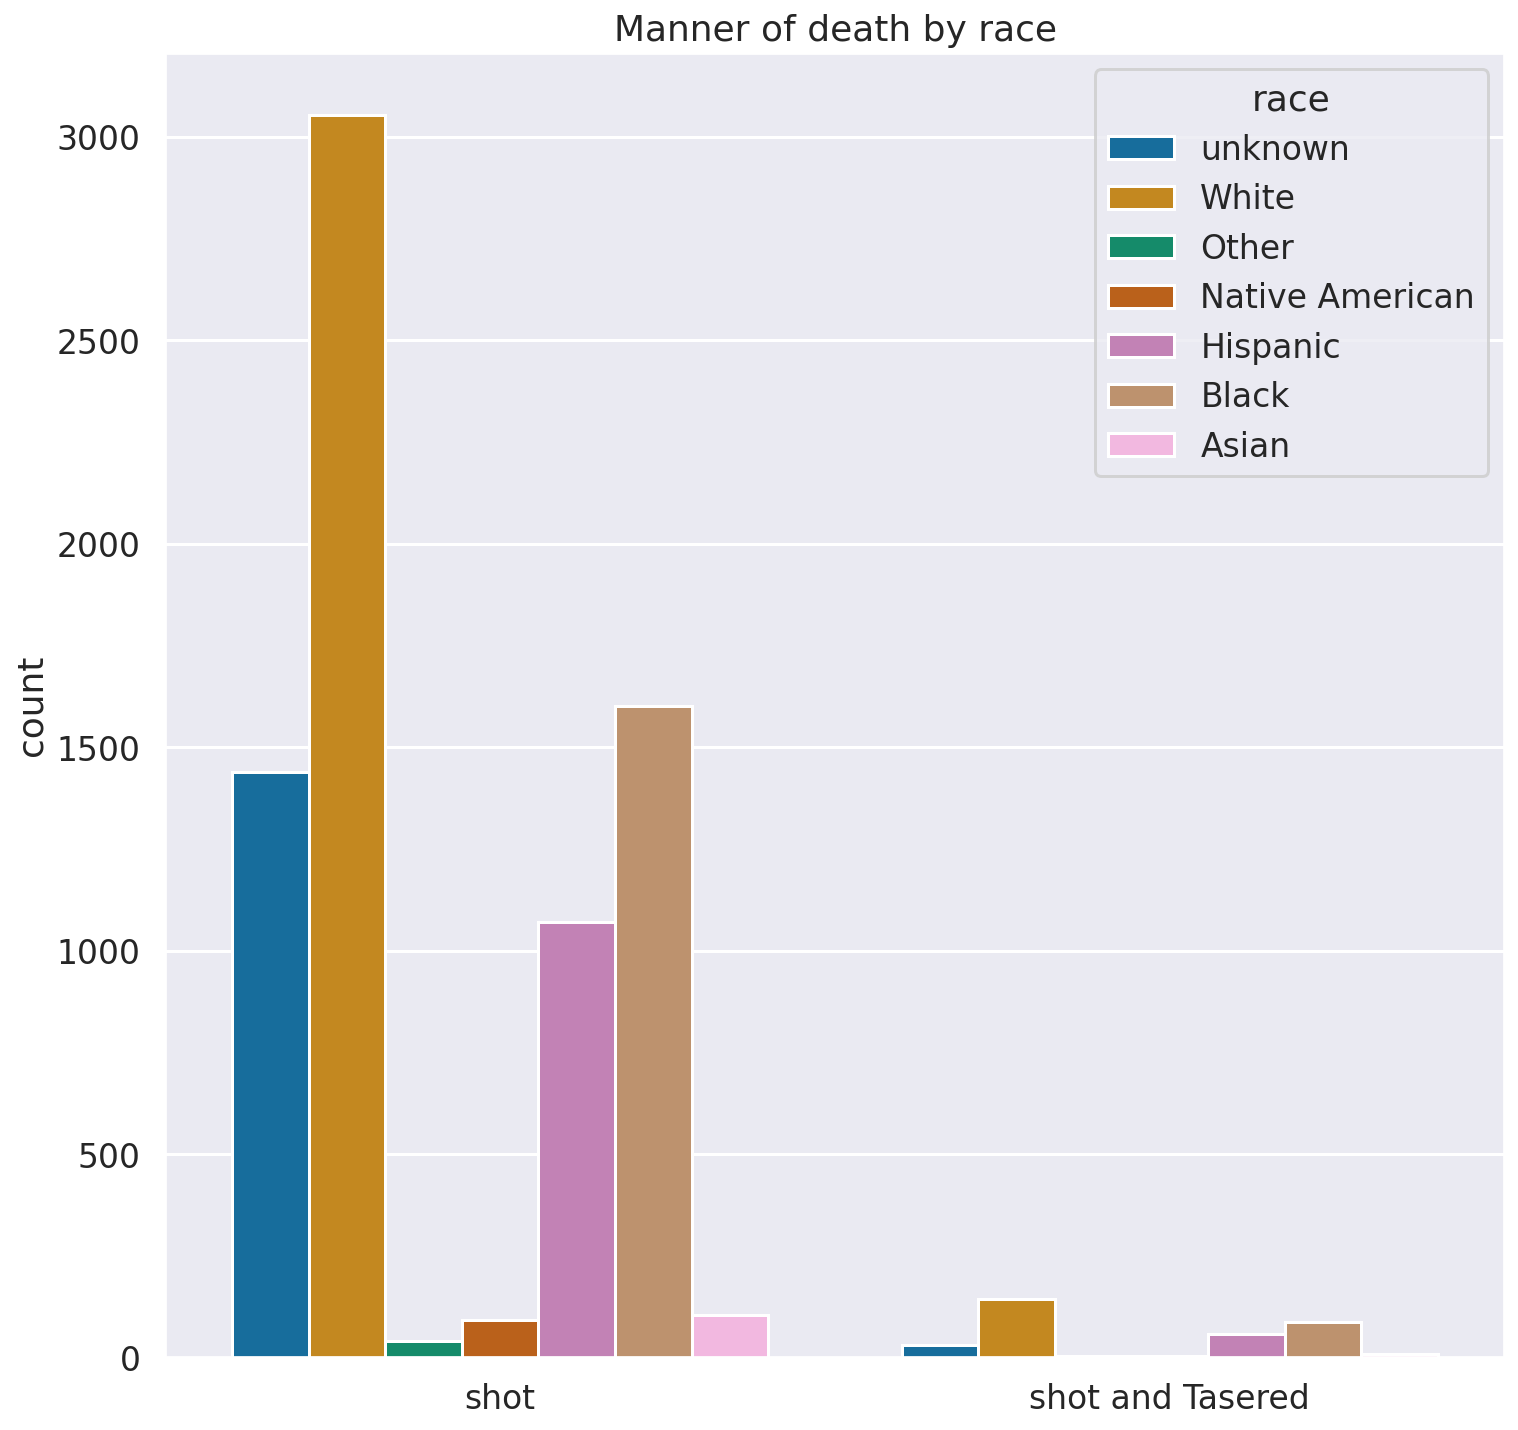

In [146]:
fig = plt.figure(figsize=(12, 12))

sns.countplot(x=shootings_df["manner_of_death"], hue=shootings_df["race"])

plt.title("Manner of death by race")
plt.xlabel("")
plt.show()


It would look suspicious that police rarely tries to tase people before shooting them, but the reality is that tasers often don't work because suspects are on adrenaline rush and their bodies won't care about getting tased. Not to mention how dangerous it is to try and tase someone who has a lethal weapon.

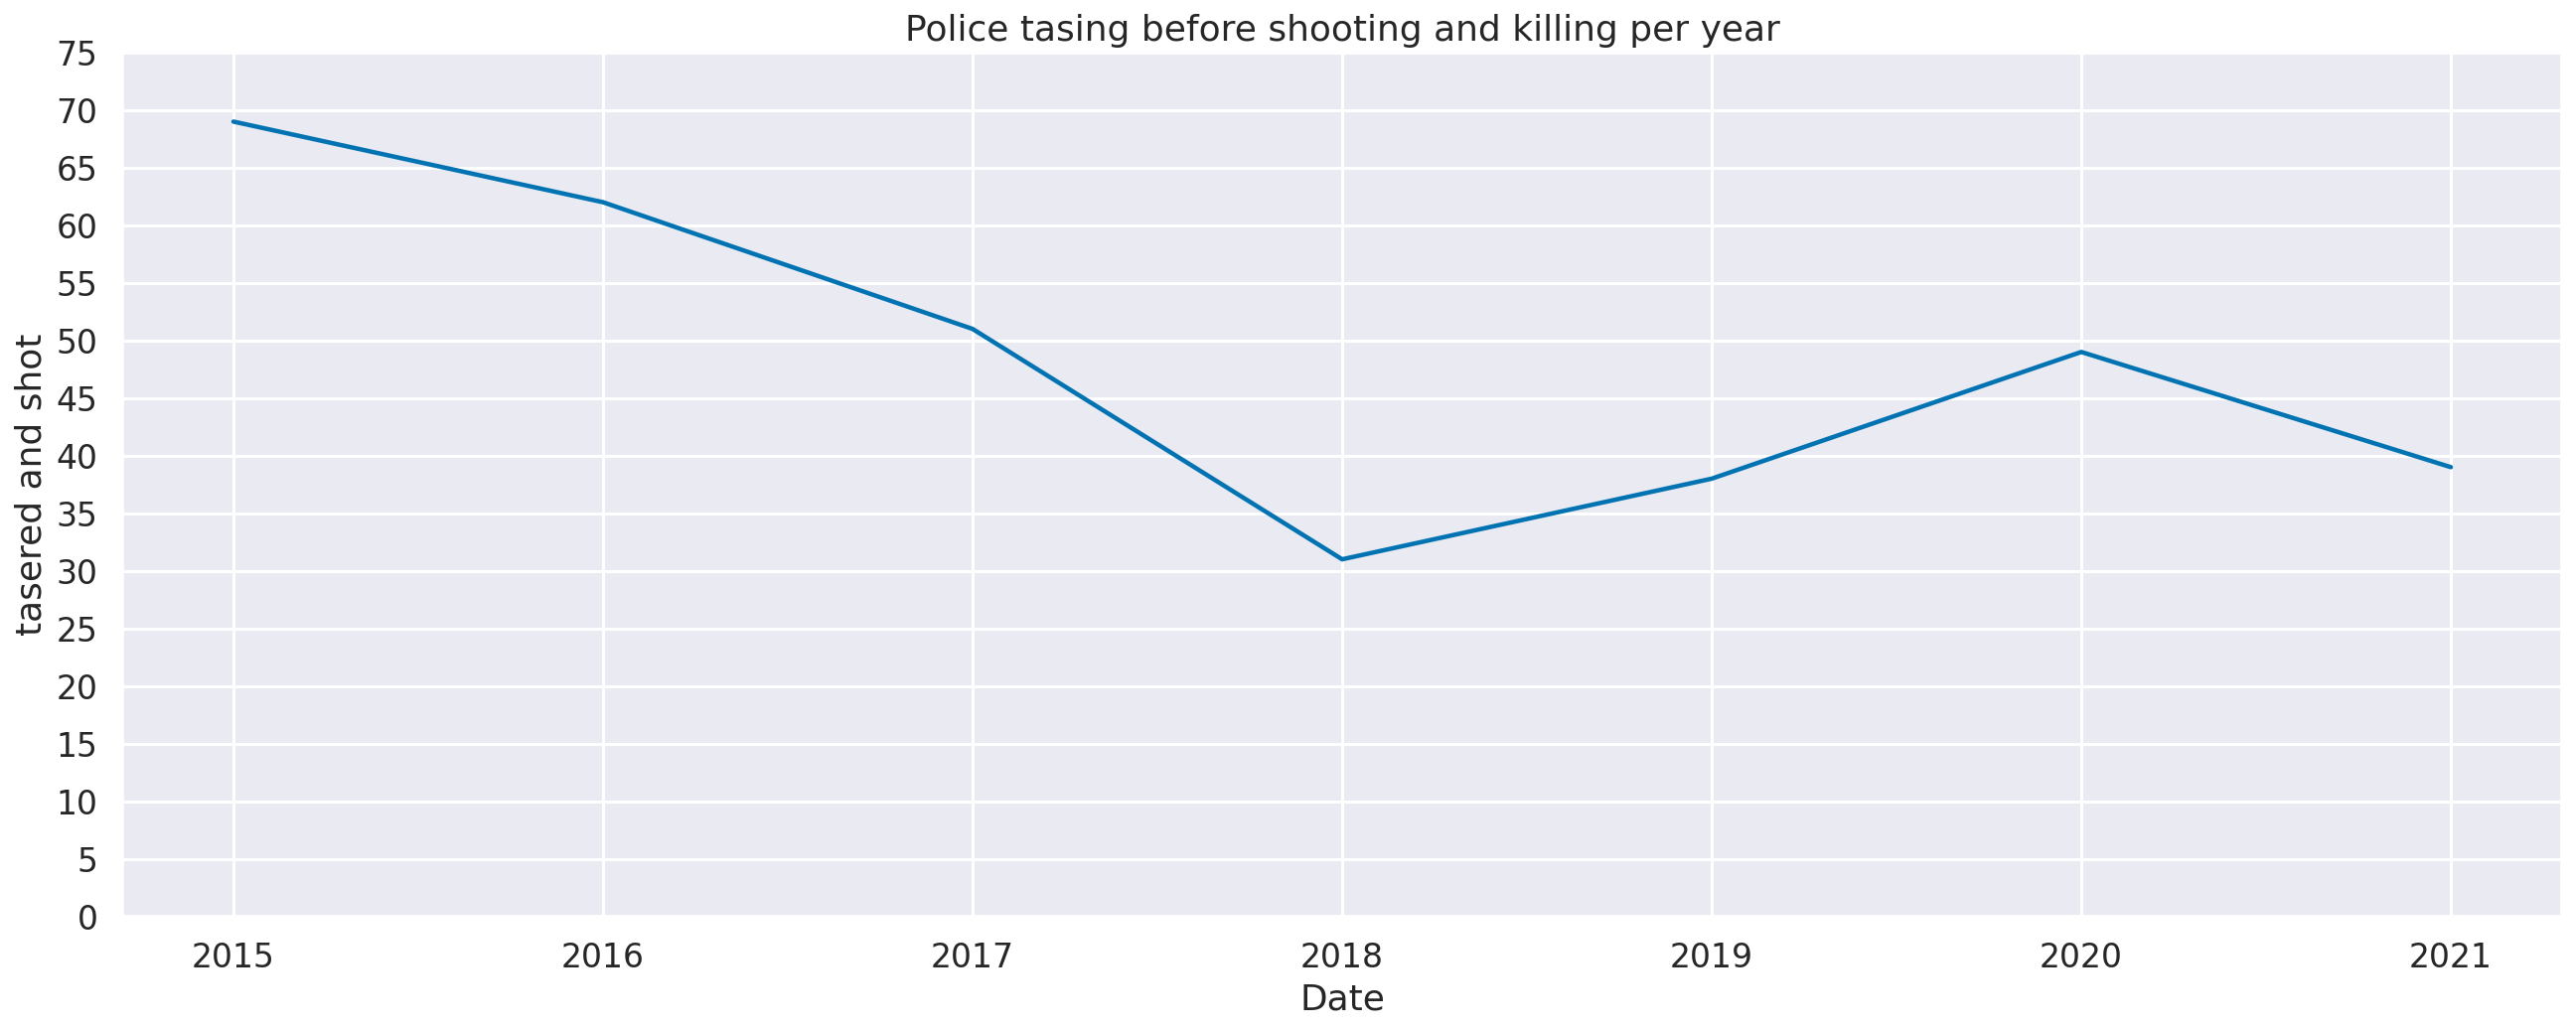

In [147]:
tased_grp = shootings_df.groupby("manner_of_death").get_group("shot and Tasered")
tased_series_y = tased_grp.resample(rule="Y", on="date")["id"].count()
tased_series_y.index = tased_series_y.index.year
fig = plt.figure(figsize=(22, 8))

g = sns.lineplot(data=tased_series_y, x=tased_series_y.index, y=tased_series_y)
g.set_yticks([i * 5 for i in range(16)])

plt.ylabel("tasered and shot")
plt.xlabel("Date")
plt.title("Police tasing before shooting and killing per year")
plt.show()


Decided it might be intresting to look at police tasing before shooting per year graph. It shows that 2015-2018 cases of people getting tased before getting shot dropped down, this might be because of previously mentioned reason that tasers are unreliable and ineffective.

### Cities with most deaths

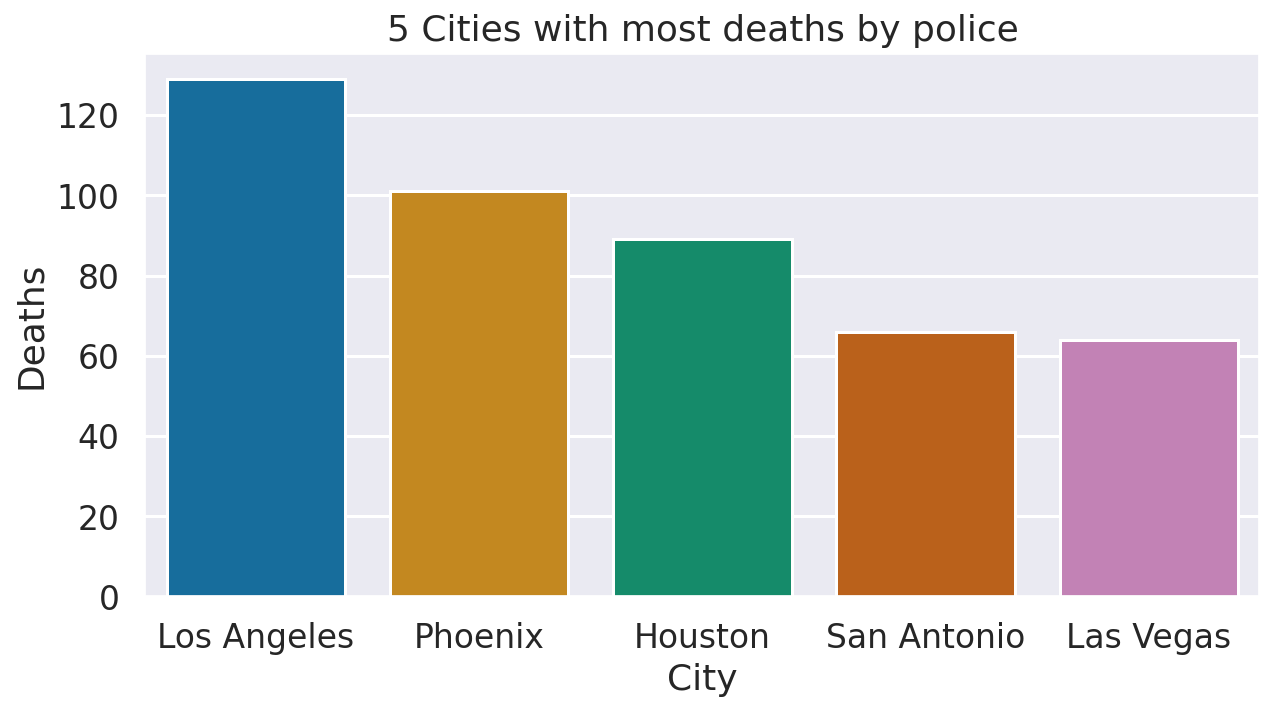

In [148]:
city_group = shootings_df.groupby("city")
deadliest_cities = city_group.count()["id"].nlargest(5)
fig, ax = plt.subplots(figsize=(10, 5))

sns.barplot(
    data=shootings_df, x=deadliest_cities.index, y=deadliest_cities, ax=ax,
)

plt.xlabel("City")
plt.ylabel("Deaths")
plt.title("5 Cities with most deaths by police")
plt.show()


All of these cities have really high density of population.

### States with most deaths

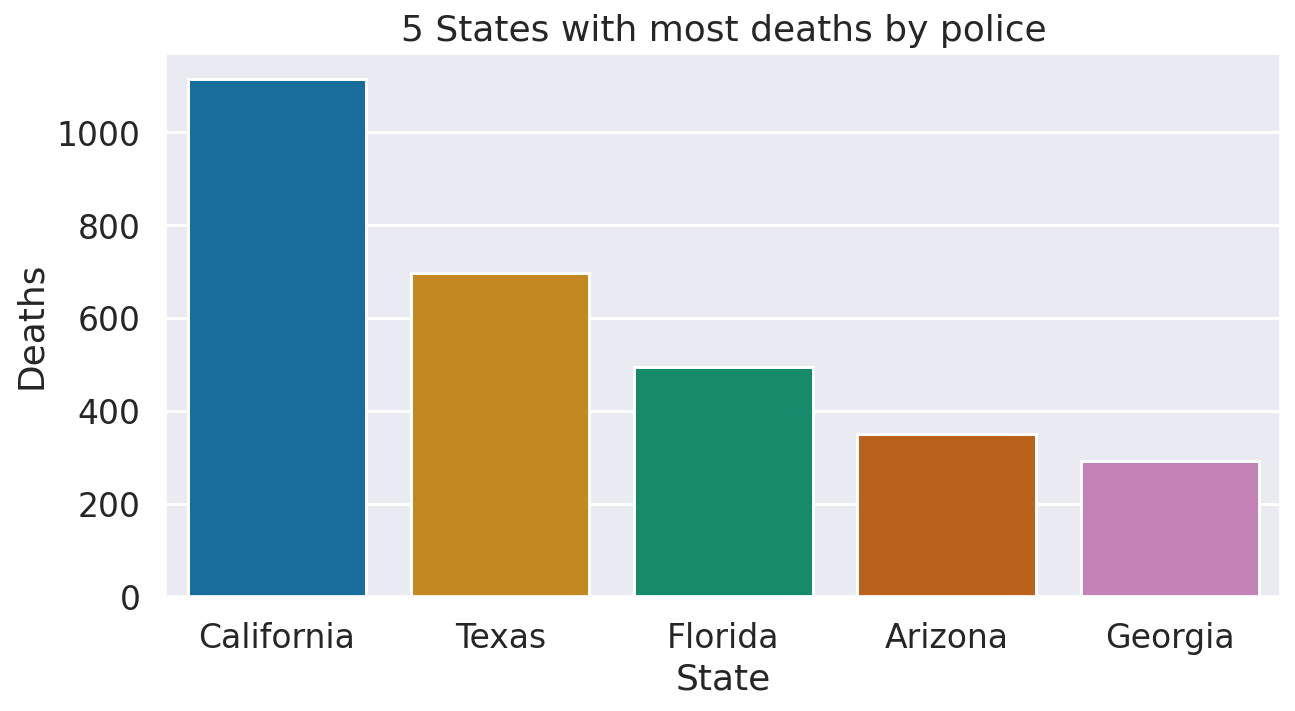

In [149]:
deadliest_states = full_df["DEATHS"].nlargest(5)
fig, ax = plt.subplots(figsize=(10, 5))

sns.barplot(data=shootings_df, x=deadliest_states.index, y=deadliest_states, ax=ax)

plt.xlabel("State")
plt.ylabel("Deaths")
plt.title("5 States with most deaths by police")
plt.show()


In [150]:
full_df["POPULATION"].nlargest(10)

NAME
California        39995077
Texas             29945493
Florida           22085563
New York          20365879
Pennsylvania      13062764
Illinois          12808884
Ohio              11852036
Georgia           10916760
North Carolina    10620168
Michigan          10116069
Name: POPULATION, dtype: int64

As well as cities the more population state has, the more deaths occur there with some exceptions. Three out of five states shown in this chart are also in top 10 states with biggest populations in America.

In [151]:
corr = full_df["POPULATION"].corr(full_df["DEATHS"])
corr


0.8955395747230328

## As we can see the is a strong correlation between the size of the population and the number of deaths.

#### Most common weapons

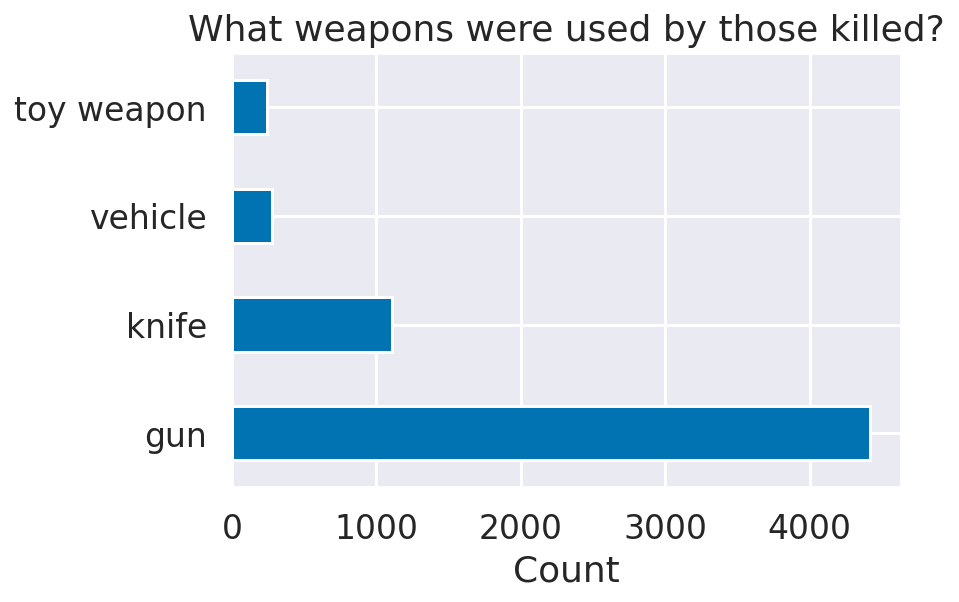

In [152]:
weapon_series=shootings_df['armed'].value_counts()
weapon_series.drop(['unarmed', 'undetermined'], inplace=True)
weapon_series=weapon_series.nlargest(4)
plt.figure()
weapon_series.plot(kind='barh')
plt.title('What weapons were used by those killed?')
plt.xlabel('Count')
plt.show()

Guns and knives were expected to be in this graph, toy weapons are quite a surprize.

#### Armed pie chart

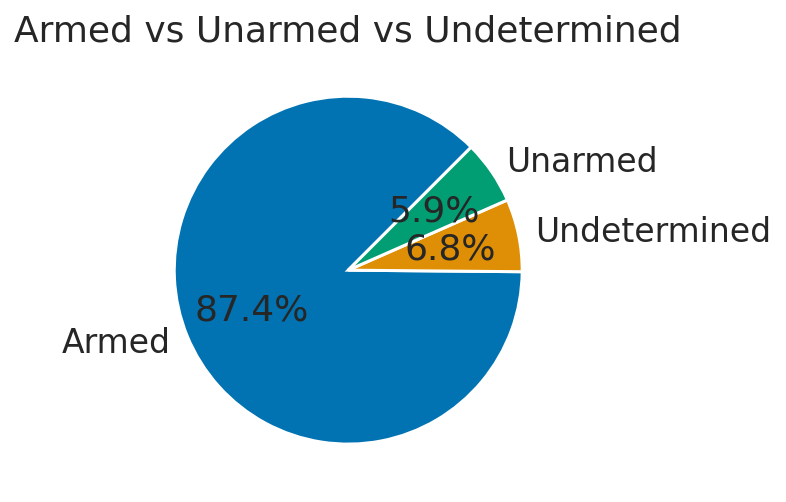

In [153]:
unarmed = len(shootings_df["armed"].loc[shootings_df["armed"].isin(["unarmed"])])
undetermined = len(
    shootings_df["armed"].loc[shootings_df["armed"].isin(["undetermined"])]
)
armed = len(
    shootings_df["armed"].loc[~shootings_df["armed"].isin(["unarmed", "undetermined"])]
)
fig = plt.figure()
data = [armed, undetermined, unarmed]
labels = ["Armed", "Undetermined", "Unarmed"]
plt.pie(data, labels=labels, autopct="%.1f%%", startangle=45, labeldistance=1.1)
plt.title("Armed vs Unarmed vs Undetermined")
plt.show()


## We can see that most of the people who got killed by police were armed and therefore considered dangerous.

Let's take a look at lowest gun possesion percentages of those who got killed by police in each state.

In [154]:
states_group = shootings_df.groupby("state")
armed_states = states_group["armed"].value_counts(normalize=True)
armed_states_df = pd.DataFrame(armed_states)

result_df = armed_states_df.loc[
    armed_states_df.index.get_level_values("armed") == "gun"
]
result_df = result_df.droplevel("armed", axis=0)
result_df.rename(columns={"armed": "gun_pct"}, inplace=True)
result_df["gun_pct"].nsmallest(10)


state
VT    0.307692
HI    0.351351
CT    0.363636
MA    0.370370
NJ    0.397727
CA    0.429596
ND    0.444444
WA    0.474178
ME    0.484848
RI    0.500000
Name: gun_pct, dtype: float64

In [155]:
gun_law_df.head(10)

,lawsRank,grade2019,gunDeathRate
State,,,
California,1,A,7.45
New Jersey,2,A,4.75
Connecticut,3,A-,4.91
New York,4,A-,4.03
Hawaii,5,A-,4.03
Maryland,6,A-,11.61
Massachusetts,7,A-,3.46
Illinois,8,A-,10.78
Rhode Island,9,B+,3.28


## As we can see 7 out of 10 states (California, New Jersey, Connecticut, Hawaii, Massachusetts, Rhode Island, Washington) with smallest gun possession percentages are also in top 10 states with strictest gun laws dataset.

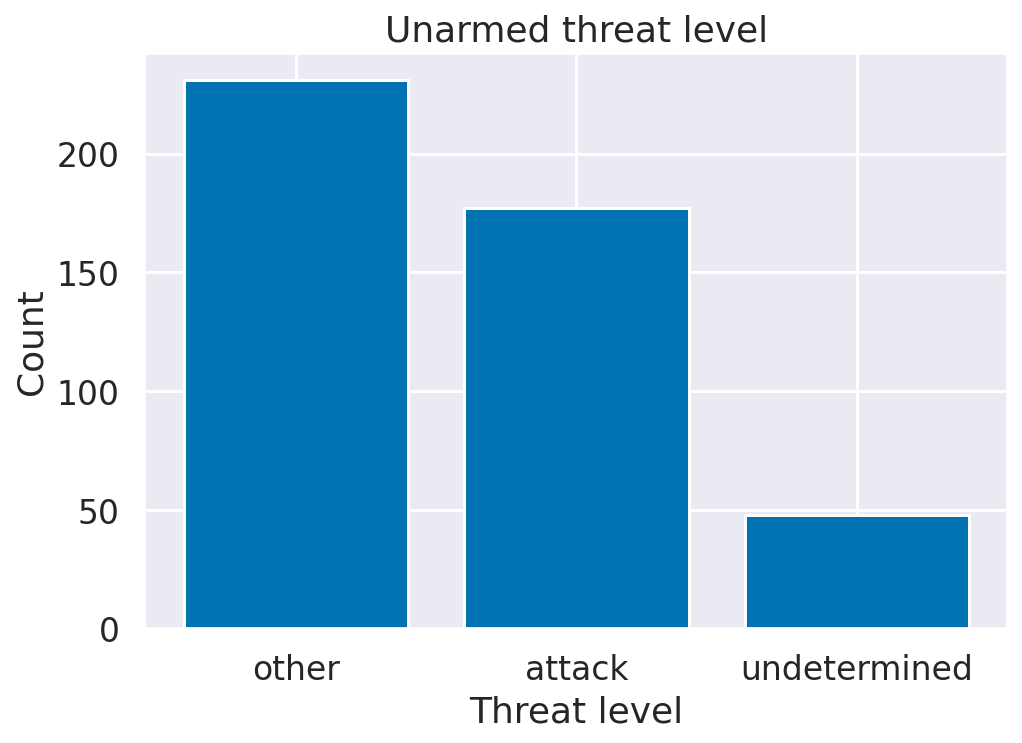

In [156]:
unarmed_threat = shootings_df.groupby("armed").get_group("unarmed")["threat_level"]
unarmed_threat = unarmed_threat.value_counts()
fig = plt.figure()

ax = fig.add_axes([0, 0, 1, 1])
ax.bar(unarmed_threat.index, unarmed_threat)

plt.xlabel("Threat level")
plt.ylabel("Count")
plt.title("Unarmed threat level")
plt.show()


## Cases with unarmed people getting killed should be investigated more given the fact that in majority of these cases people are of 'Other' threat level. This issue looks really suspicious to me

## Mental illness

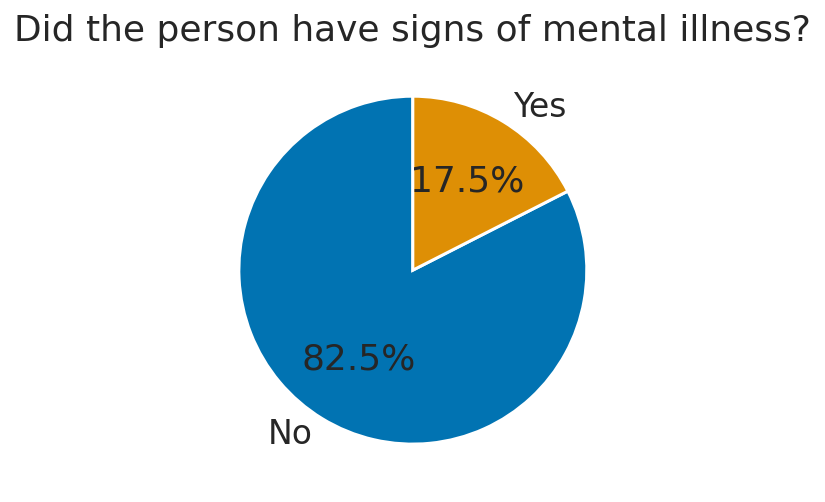

In [157]:
mental_illness = shootings_df["signs_of_mental_illness"].sum()
fig, ax = plt.subplots()

data = [len(shootings_df), mental_illness]

labels = ["No", "Yes"]
plt.pie(data, labels=labels, autopct="%.1f%%", startangle=90)

plt.title("Did the person have signs of mental illness?")
plt.show()


In [158]:
print(
    f"1 in {(len(shootings_df)/mental_illness).round(1)} "
    + "people in this dataset had signs of mental illness"
)


1 in 4.7 people in this dataset had signs of mental illness


As we can see quite a big portion of people who got killed had signs of mental illness. This is obviously a big issue and something has to be done about this.

#### Suicide by cop

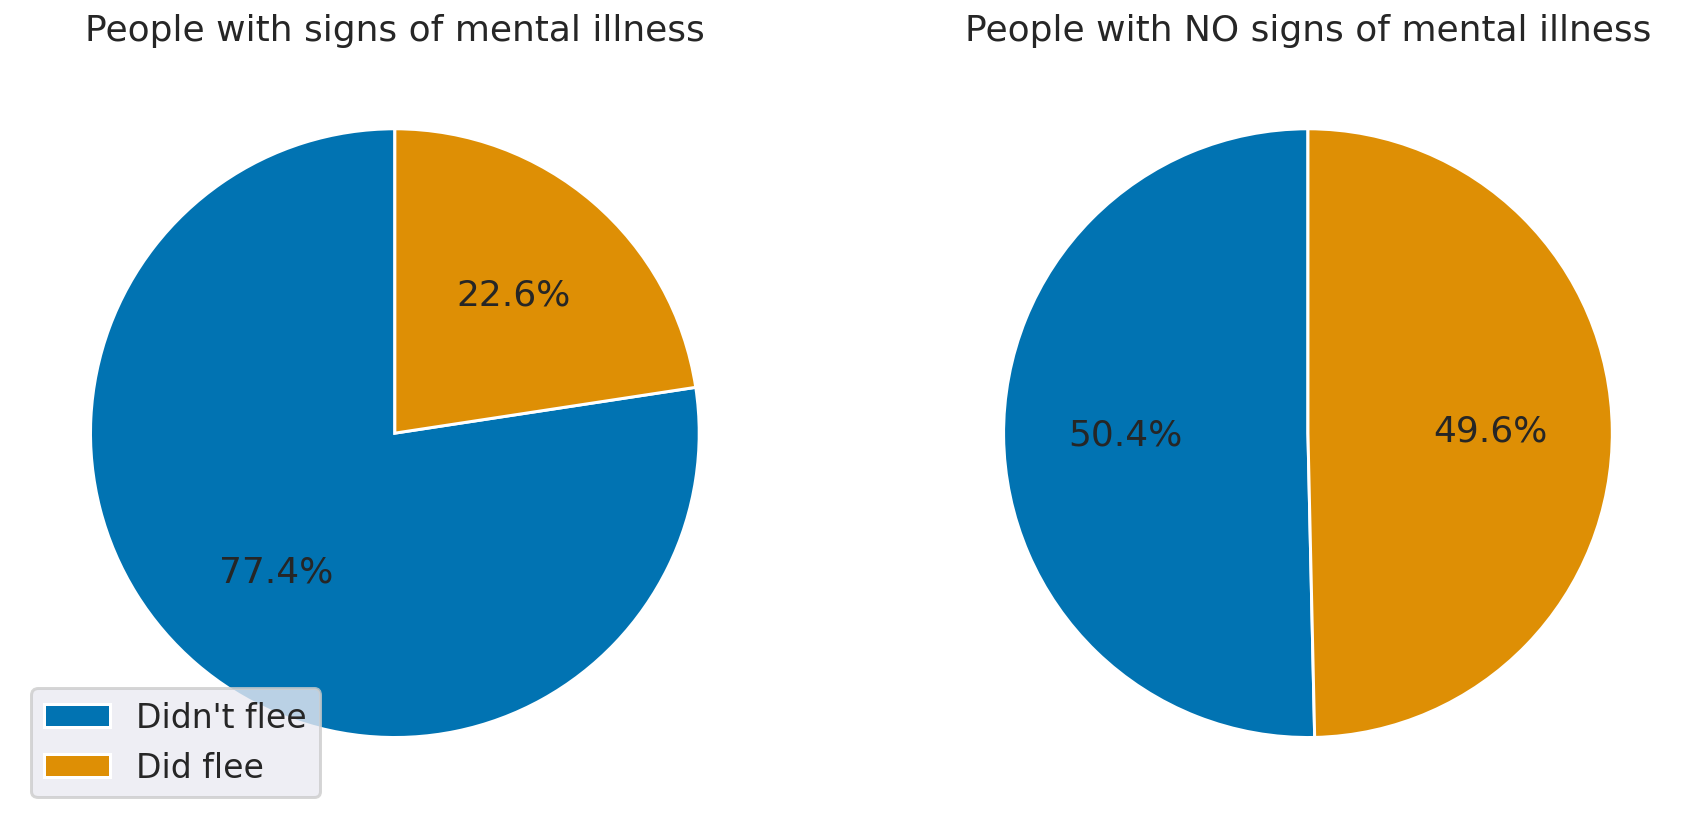

In [159]:
flee_armed = shootings_df.groupby(["flee"])
mental_illness_nflee = flee_armed.get_group("Not fleeing")[
    "signs_of_mental_illness"
].sum()
no_mental_illness_nflee = (
    ~flee_armed.get_group("Not fleeing")["signs_of_mental_illness"]
).sum()
no_mental_ilness = len(shootings_df) - mental_illness
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
data = [mental_illness_nflee, mental_illness - mental_illness_nflee]

labels = ["Didn't flee", "Did flee"]

ax1.pie(data, autopct="%.1f%%", startangle=90)

ax1.title.set_text("People with signs of mental illness")

data = [no_mental_illness_nflee, no_mental_ilness - no_mental_illness_nflee]

ax2.pie(data, autopct="%.1f%%", startangle=90)

ax2.title.set_text("People with NO signs of mental illness")

ax1.legend(labels, loc="lower left")
plt.show()


In [160]:
print(f'1 in {(mental_illness/(mental_illness-mental_illness_nflee)).round(1)} '
+ 'people WITH signs of mental illness did flee from police')
print(f'1 in {(no_mental_ilness/(no_mental_ilness-no_mental_illness_nflee)).round(1)} '
+ 'people WITHOUT signs of mental illness did flee from police')

1 in 4.4 people WITH signs of mental illness did flee from police
1 in 2.0 people WITHOUT signs of mental illness did flee from police


At first glance this pie chart might not look important, but it is. We see that higher percentage of people who had signs of mental illness decided not to flee when compared to people with no signs of mental illness. Some of these cases where a person had signs of mental illness and didn't flee might be linked to suicide attempts. Suicidal people sometimes decide to call the police on themselves, threaten officers with a weapon and get killed. This is what law enforcement officers call "Suicide by cop". It is more common than someone might expect. 11% of officer-involved shootings happen because of this.

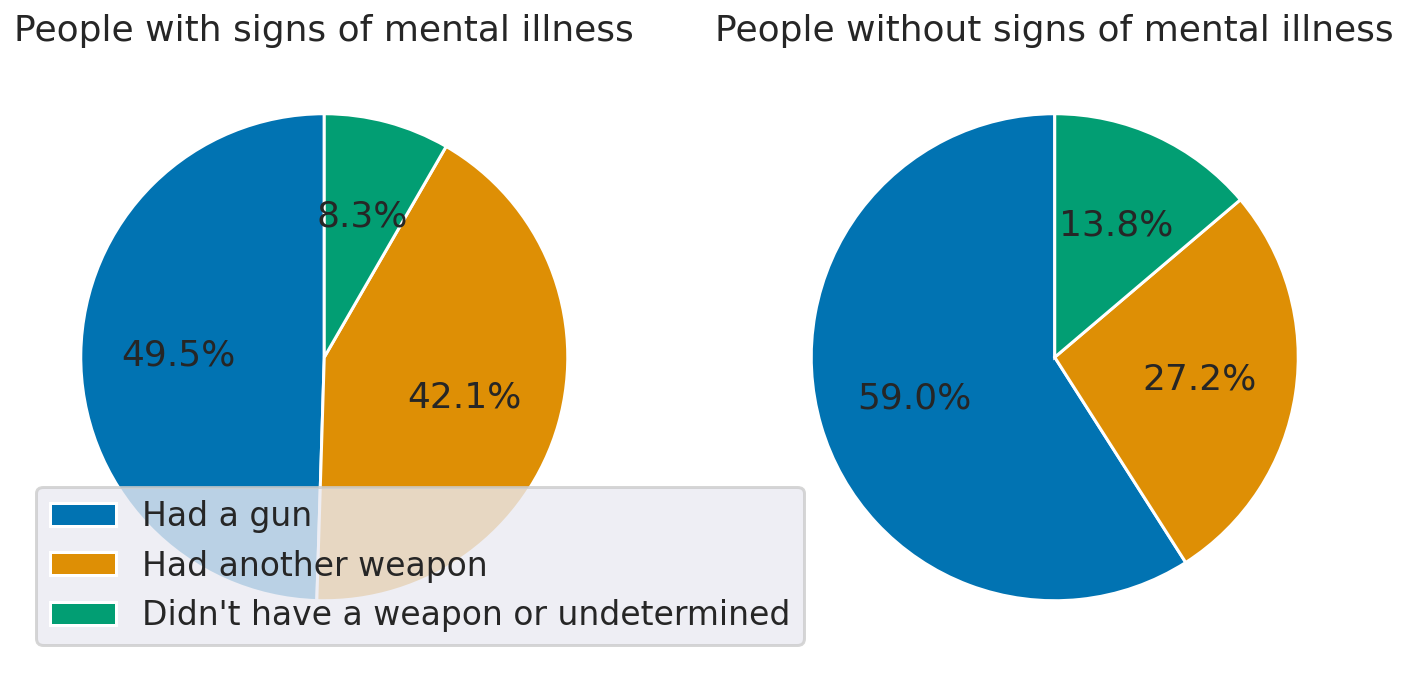

In [161]:
armed_mental = shootings_df.groupby(["armed"])
armed_mental_sum = armed_mental.get_group("gun")["signs_of_mental_illness"].sum()

unarmed_mental_sum = armed_mental.get_group("unarmed")["signs_of_mental_illness"].sum()
undetermined_mental_sum = armed_mental.get_group("undetermined")[
    "signs_of_mental_illness"
].sum()

no_weapons_sum = unarmed_mental_sum + undetermined_mental_sum

armed_not_mental = (~armed_mental.get_group("gun")["signs_of_mental_illness"]).sum()
unarmed_not_mental_sum = (
    ~armed_mental.get_group("unarmed")["signs_of_mental_illness"]
).sum()
undetermined_not_mental_sum = (
    ~armed_mental.get_group("undetermined")["signs_of_mental_illness"]
).sum()

no_mental_no_weapon = unarmed_not_mental_sum + undetermined_not_mental_sum
all_not_mental_sum = len(shootings_df) - mental_illness

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))

data = [
    armed_mental_sum,
    mental_illness - armed_mental_sum - no_weapons_sum,
    no_weapons_sum,
]

labels = ["Had a gun", "Had another weapon", "Didn't have a weapon or undetermined"]

ax1.pie(data, autopct="%.1f%%", startangle=90)

data_ = [
    armed_not_mental,
    all_not_mental_sum - armed_not_mental - no_mental_no_weapon,
    no_mental_no_weapon,
]

ax2.pie(data_, autopct="%.1f%%", startangle=90)
ax1.legend(labels, loc="lower left")
ax1.title.set_text("People with signs of mental illness")
ax2.title.set_text("People without signs of mental illness")

plt.show()


## Again we can see that gun control is an issue in America. Almost 50% of people who had signs of mental illness and got killed had a gun. That is only 10% less than people who didn't have signs of mental illness. We can make an assumption that mentally ill people have the same access to guns as people without mental illness. This should not be happening, mental health checks should be taken into consideration when selling guns.

In [162]:
corr_ = shootings_df["age"].corr(shootings_df["signs_of_mental_illness"])
corr_


0.09822206927225972

Tried checking whether age and signs of mental illness had any correlation but our result of 0.09 is too close to 0 to say that these two features are connected.

### Deaths per state map

In [163]:
states = shootings_df.groupby('state').agg({'id':'count'}).reset_index()

fig = go.Figure(data = go.Choropleth(
    locations = states['state'],
    z = states['id'],
    locationmode = "USA-states",
    colorbar_title = "Deaths"))

fig.update_layout(
    title_text = "Deaths per state map",
    geo_scope = "usa")

fig.show()



But we shouldn't judge much by this. Every state has different amounts of citizens, different laws and different issues in their communities.

More appropriatly we can judge states by deaths per capita (100 000 POP).

##### Deaths per capita feature

In [164]:
(full_df.describe().apply(lambda x: x.apply("{:n}".format))["DEATHS_PER_STATE_CAPITA"])

count          51
mean      2.70354
std       1.49538
min      0.542328
25%       1.69787
50%       2.41024
75%       3.29231
max       7.79639
Name: DEATHS_PER_STATE_CAPITA, dtype: object

### On average in America 5.7 people per 100K population die of police. Of course states differ from each other: the lowest value is 0.13 and the highest is 63.

## States with higest deaths per capita

In [165]:
full_df.loc[full_df["DEATHS_PER_STATE_CAPITA"].nlargest(10).index]


,POPULATION,STATE,DEATHS,DEATHS_PER_STATE_CAPITA
NAME,,,,
New Mexico,2129190,NM,166,7.796392
Alaska,738023,AK,53,7.181348
Oklahoma,4000953,OK,212,5.298738
Arizona,7303398,AZ,351,4.805982
Colorado,5922618,CO,279,4.710755
Wyoming,579495,WY,26,4.486665
Montana,1103187,MT,49,4.441677
West Virginia,1781860,WV,73,4.096843
Nevada,3185426,NV,125,3.924122


## States with lowest deaths per capita

In [166]:
full_df.loc[full_df["DEATHS_PER_STATE_CAPITA"].nsmallest(10).index]


,POPULATION,STATE,DEATHS,DEATHS_PER_STATE_CAPITA
NAME,,,,
Rhode Island,1106341,RI,6,0.542328
Connecticut,3612314,CT,22,0.609028
New York,20365879,NY,140,0.687424
Massachusetts,7126375,MA,54,0.757749
New Jersey,9388414,NJ,88,0.937326
Pennsylvania,13062764,PA,161,1.232511
Illinois,12808884,IL,158,1.233519
Michigan,10116069,MI,131,1.294969
Minnesota,5787008,MN,86,1.486087


## States with strictest gun laws

In [167]:
gun_law_df.head(10)


,lawsRank,grade2019,gunDeathRate
State,,,
California,1,A,7.45
New Jersey,2,A,4.75
Connecticut,3,A-,4.91
New York,4,A-,4.03
Hawaii,5,A-,4.03
Maryland,6,A-,11.61
Massachusetts,7,A-,3.46
Illinois,8,A-,10.78
Rhode Island,9,B+,3.28


As we can see half of states with lowest deaths per capita (Rhode Island, Connecticut, New York, Massachusetts, New Jersey, Illinois) are states with strictest gun laws.

## This makes obvious the fact that strict gun laws are saving lifes

### Police reforms

Let's take a look at the impact reforms and BLM protests had.

In [168]:
death_count_year = shootings_df.resample(rule="Y", on="date")["id"].count()
death_count_year.index = death_count_year.index.year


#### Deaths each year

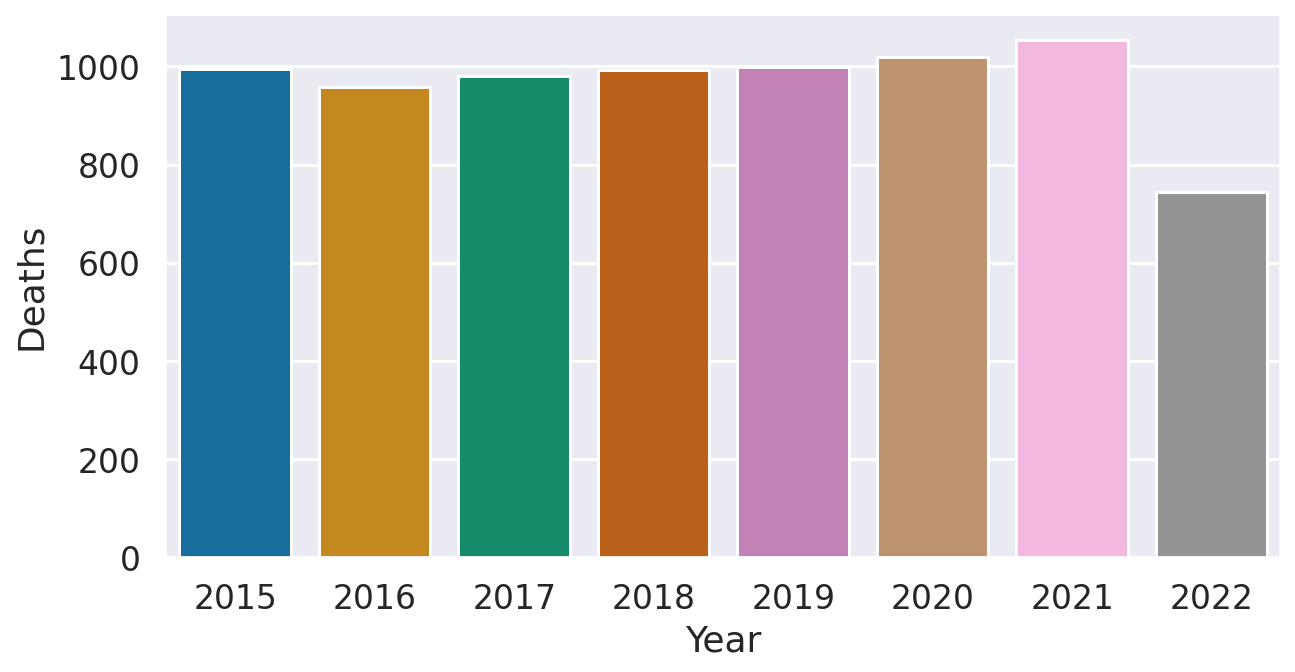

In [169]:
fig = plt.figure(figsize=(10, 5))

g = sns.barplot(x=death_count_year.index, y=death_count_year)

plt.ylabel("Deaths")
plt.xlabel("Year")
plt.show()


We see that since 2016 to 2021 deaths per year has been slowly rising up. 2022 has less deaths because we dont have all data from October, November and December of 2022.

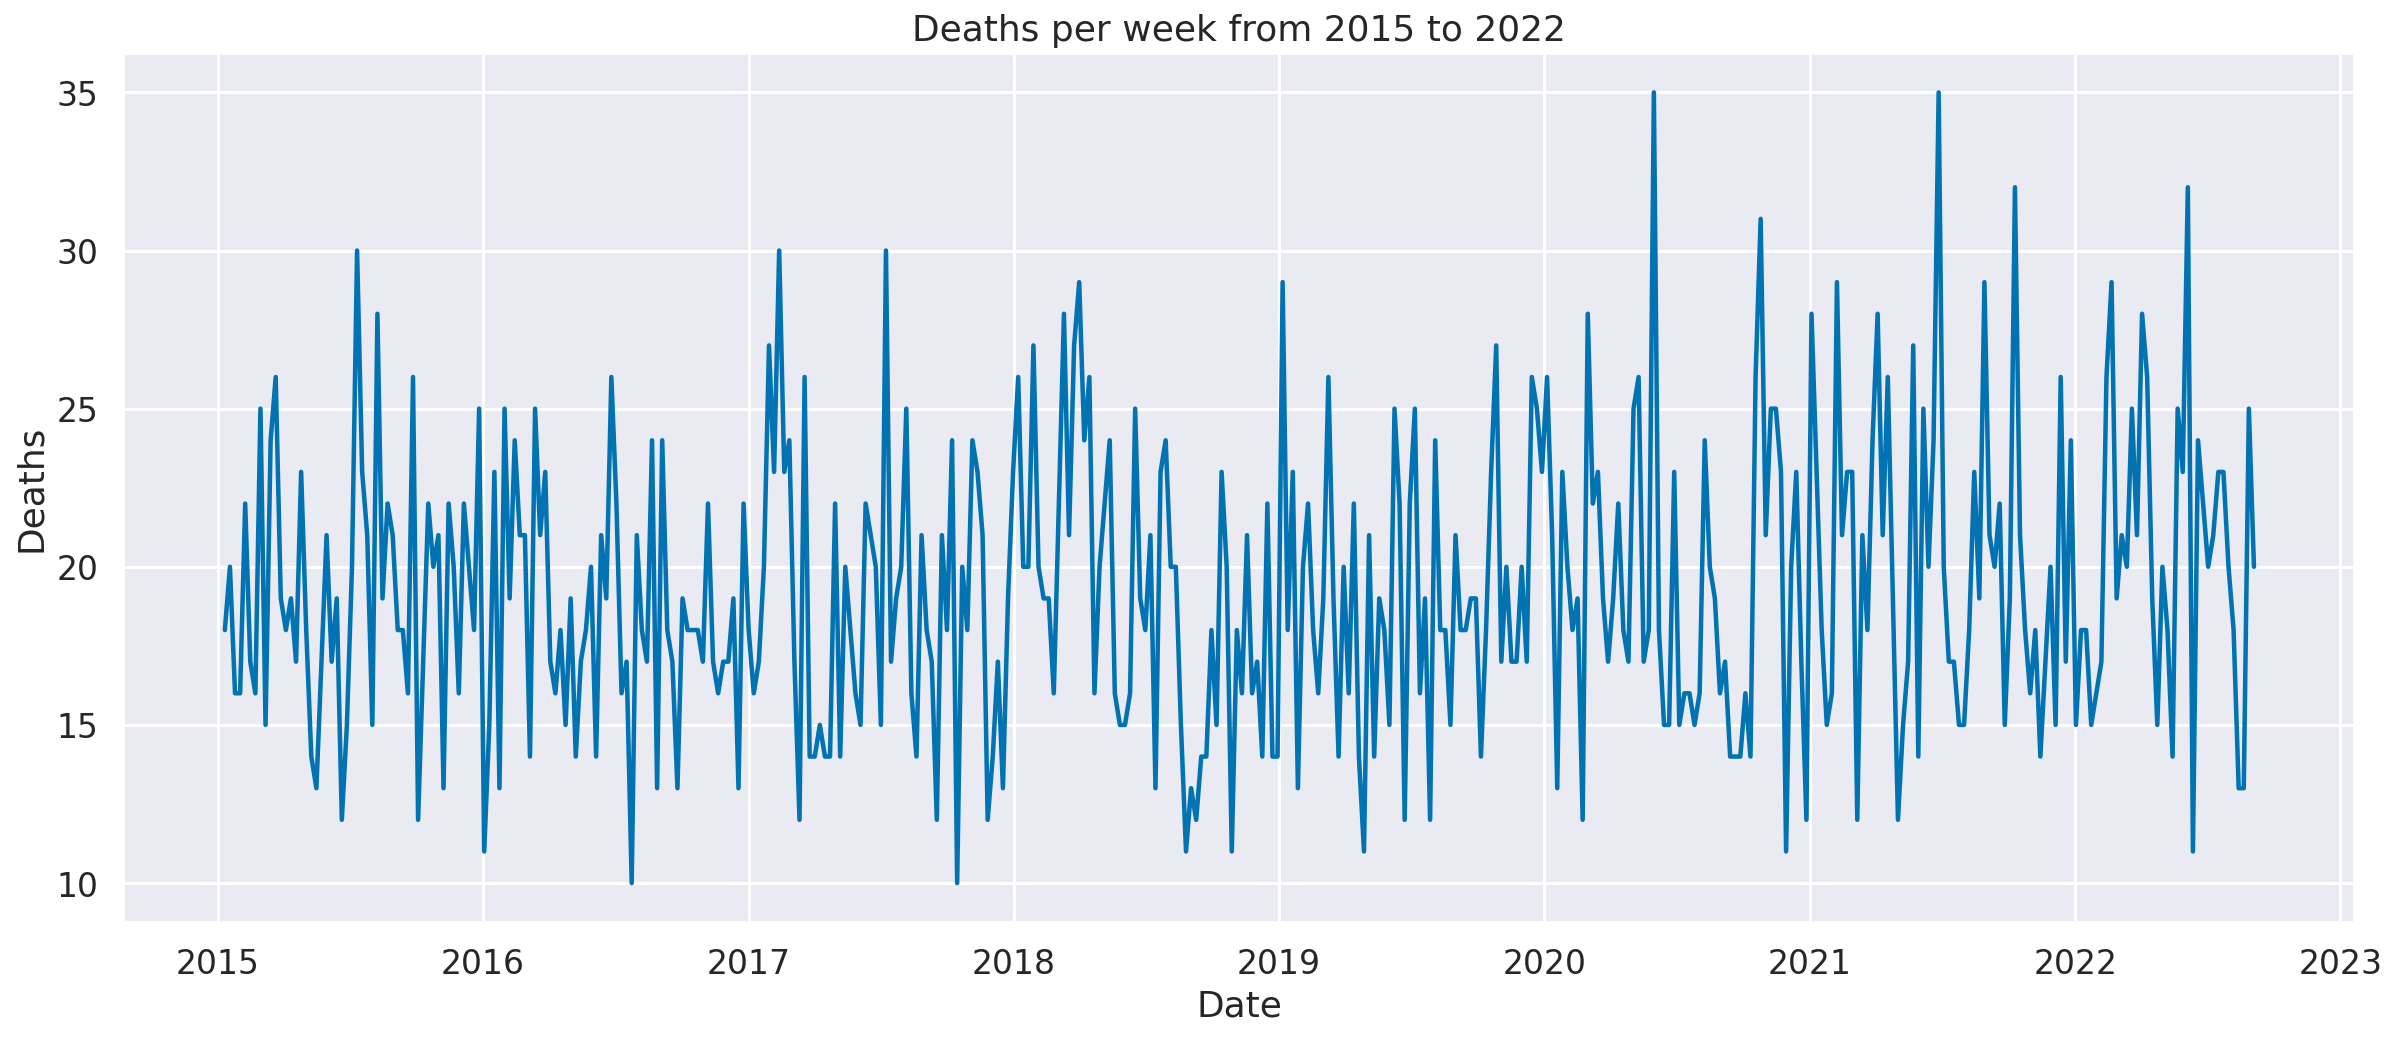

In [170]:
death_count = shootings_df.resample(rule="W", on="date")["id"].count()
death_count.drop(death_count.tail(2).index, inplace=True)
death_count.drop(death_count.head(1).index, inplace=True)
fig = plt.figure(figsize=(20, 8))

sns.lineplot(data=death_count, x="date", y=death_count)

plt.ylabel("Deaths")
plt.xlabel("Date")
plt.title("Deaths per week from 2015 to 2022")
plt.show()


In [171]:
death_count.idxmax()

Timestamp('2020-05-31 00:00:00', freq='W-SUN')

Decided to look at the bloodiest week throughout the 7 years. Turns out that it was the week after George Floyd death. Because of the unordinary situation decided not to put it in when counting the average deaths per week before and after.

In [172]:
before_mean = death_count["2015-01-04":"2020-05-25"].mean()
past_mean = death_count["2020-06-01":].mean()

print(f"Deaths per week before George Floyd protests: {before_mean}")
print(f"Deaths per week after George Floyd protests: {past_mean}")


Deaths per week before George Floyd protests: 18.97864768683274
Deaths per week after George Floyd protests: 19.88135593220339


## We can see that average deaths per week value has _increased_ by 0.9.

#### Impact on California

One of the biggest states that had issued the police reforms is California.

##### California cities

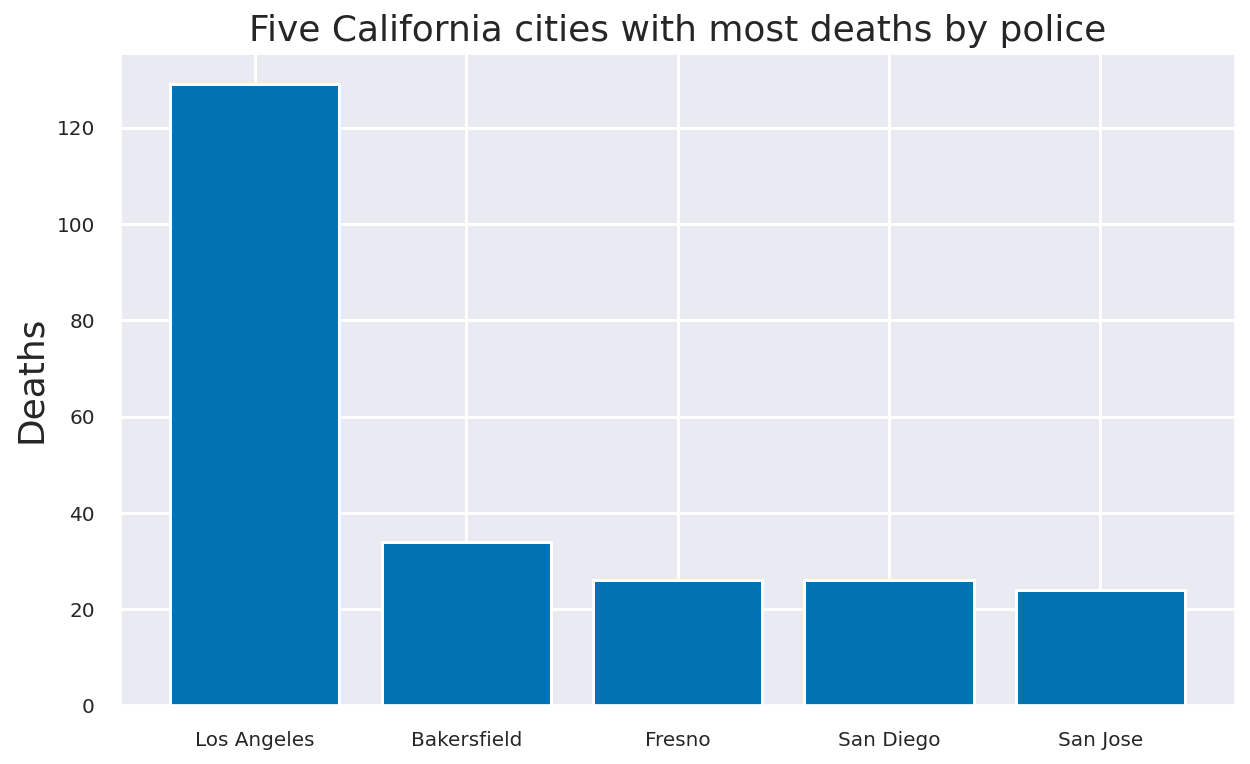

In [173]:
cali_group = shootings_df.groupby("state").get_group("CA")
cali_cities = cali_group.groupby("city").count()["id"].nlargest(5)
fig = plt.figure(figsize=(10, 6))

ax = plt.axes()
ax.tick_params(axis="both", which="major", labelsize=10)
ax.tick_params(axis="both", which="minor", labelsize=8)
plt.bar(data=cali_cities, x=cali_cities.index, height=cali_cities)

plt.title("Five California cities with most deaths by police")
plt.ylabel("Deaths")
plt.show()


Unsurprisingly Los Angeles as the biggest city in the state has the most deaths.

##### California heatmap

In [174]:
heat_df = cali_group[["longitude", "latitude"]]
shootings_heat_map = folium.Map(location=[36.778259, -119.417931], zoom_start=7)

heat_data = [[row["latitude"], row["longitude"]] for index, row in heat_df.iterrows()]

HeatMap(heat_data, radius=9.5).add_to(shootings_heat_map)
shootings_heat_map


This is how the heatmap of California looks like, Los Angeles and around it is covered in the biggest green blob, smaller blobs contain San Francisco, San Jose, Sacramento.

##### How did deaths per week change in California before and after George Floyd protests ?

In [175]:
cali_dates = cali_group.resample(rule="M", on="date")["id"].count()
cali_dates.drop(cali_dates.tail(1).index, inplace=True)
cali_before_mean = cali_dates["2015-01-04":"2020-05-25"].mean()
cali_past_mean = cali_dates["2020-06-01":].mean()

print(
    f"California average deaths per month by police before George Floyd protests: {cali_before_mean}"
)
print(f"California average deaths per month by police after George Floyd protests: {cali_past_mean}")



California average deaths per month by police before George Floyd protests: 12.09375
California average deaths per month by police after George Floyd protests: 11.814814814814815


After the George Floyd protests the deaths per month dropped by 0.2, which is sadly quite insignificant.

In [176]:
toy_weapon_pct_usa = (
    shootings_df["armed"].value_counts(normalize=True).loc["toy weapon"]
)
toy_weapon_pct_ca = cali_group["armed"].value_counts(normalize=True).loc["toy weapon"]
print(
    f"Toy weapon possesion of those who got killed in California: {round(toy_weapon_pct_ca*100, 2)}%"
)
print(
    f"Toy weapon possesion of those who got killed in USA: {round(toy_weapon_pct_usa*100, 2)}%"
)



Toy weapon possesion of those who got killed in California: 5.92%
Toy weapon possesion of those who got killed in USA: 3.16%


It is actually illegal to have toy weapons in California. Toy weapons are twice as much common there than in the whole USA.

#### Body camera reforms

The reason of body camera use is to improve police accountability and lower reports of police misconduct. In some states one of the reforms issued is that police officers have to wear body cameras all the time.

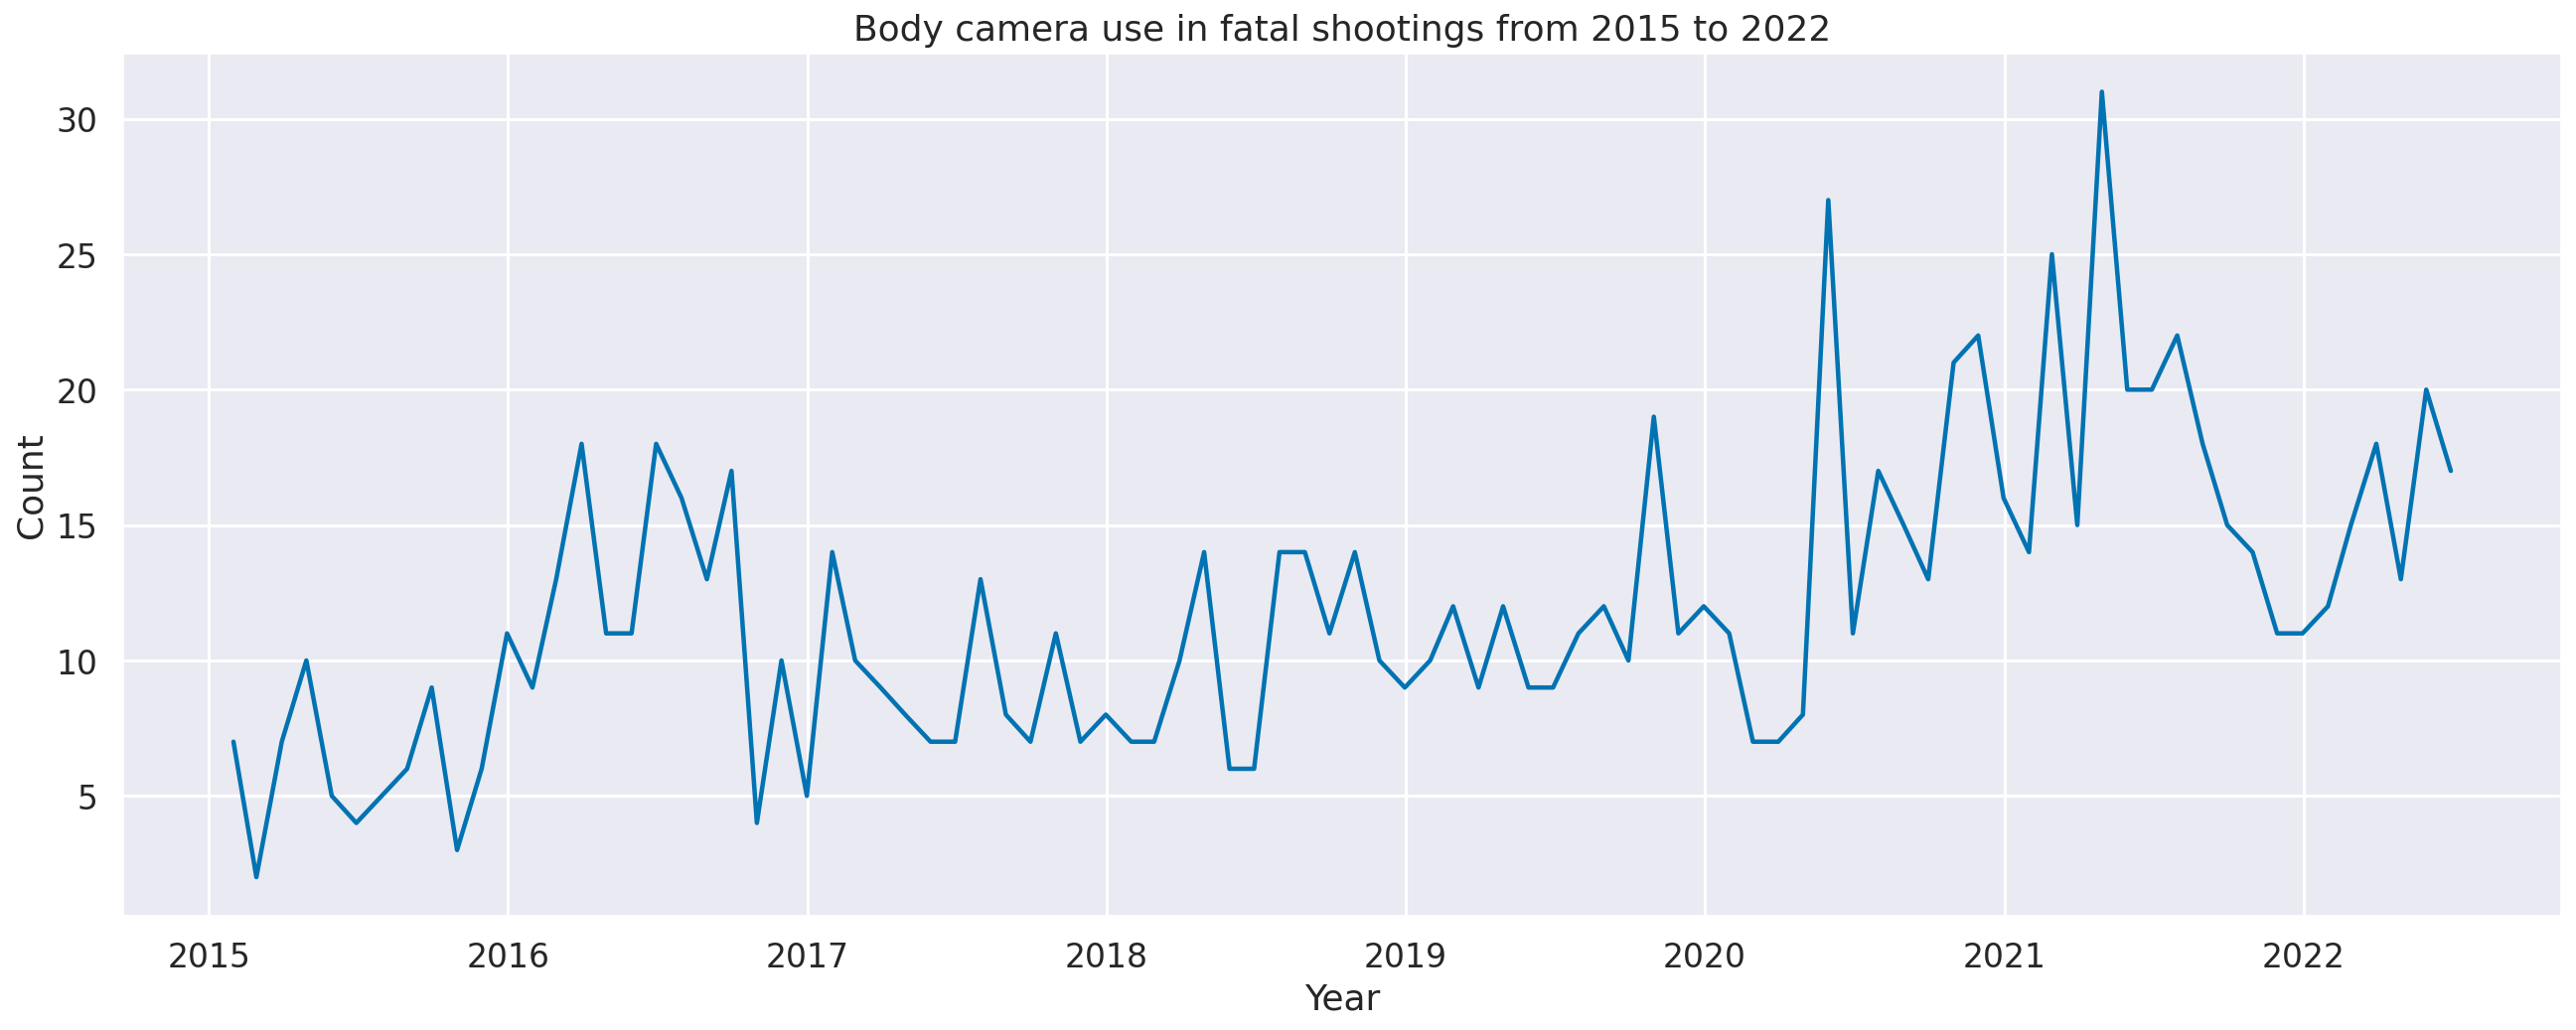

In [177]:
camera_date = shootings_df.resample(rule="M", on="date")["body_camera"].sum()
camera_date.drop(camera_date.tail(3).index, inplace=True)
fig = plt.figure(figsize=(22, 8))

sns.lineplot(data=camera_date, x="date", y=camera_date)

plt.ylabel("Count")
plt.xlabel("Year")
plt.title("Body camera use in fatal shootings from 2015 to 2022")
plt.show()


In [178]:
before_cam=camera_date['2015-01-04':'2020-05-25'].mean()
after_cam=camera_date['2020-05-25':].mean()
print(f'How many times on average body camera was used before police reforms during deadly shootings per month: {before_cam}')
print(f'How many times on average body camera was used after police reforms during deadly shootings per month: {after_cam}')

How many times on average body camera was used before police reforms during deadly shootings per month: 9.6875
How many times on average body camera was used after police reforms during deadly shootings per month: 17.423076923076923


## As we can see body camera popularity has been increased significantly (almost 2x) after reforms.

### Bonus challenge

Graph of clusters of states by population, deaths, gun possession count and people with signs of mental illness count.

In [179]:
armed_gun = states_group["armed"].value_counts()
armed_gun_df = pd.DataFrame(armed_states)

gun_df = armed_gun_df.loc[armed_gun_df.index.get_level_values("armed") == "gun"]
gun_df = gun_df.droplevel("armed", axis=0)
gun_df.rename(columns={"armed": "gun_count"}, inplace=True)
gun_df.reset_index(drop=True, inplace=True)
full_df_ = full_df.reset_index(drop=True)
mental_states = states_group["signs_of_mental_illness"].sum().reset_index(drop=True)
bonus_df = pd.concat([full_df_[["POPULATION", "DEATHS"]], gun_df["gun_count"]], axis=1)
bonus_df = bonus_df.merge(mental_states.to_frame(), left_index=True, right_index=True)


def state_label(state):
    """Gives a region label to each state"""
    if state in [
        "CO",
        "WA",
        "OR",
        "ID",
        "WY",
        "MT",
        "NV",
        "CA",
        "UT",
        "AZ",
        "NM",
        "HI",
        "AK",
    ]:
        label = "West"
        return label
    if state in [
        "ND",
        "SD",
        "NE",
        "KS",
        "MN",
        "IA",
        "MO",
        "WI",
        "IL",
        "IN",
        "MI",
        "OH",
    ]:
        label = "Midwest"
        return label
    if state in [
        "ME", 
        "NH", 
        "VT", 
        "MA", 
        "CT", 
        "RI", 
        "NY", 
        "NJ", 
        "PA"
    ]:
        label = "Northeast"
        return label
    if state in [
        "TX",
        "OK",
        "AR",
        "LA",
        "MS",
        "AL",
        "TN",
        "KY",
        "WV",
        "DC",
        "MD",
        "DE",
        "NC",
        "SC",
        "GA",
        "FL",
        "VA",
    ]:
        label = "South"
        return label


label_names = full_df["STATE"].apply(state_label)
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(label_names)
n_clusters = len(label_encoder.classes_)
preprocessor = Pipeline(
    [("scaler", MinMaxScaler()), ("pca", PCA(n_components=2, random_state=42)),]
)
clusterer = Pipeline(
    [
        (
            "kmeans",
            KMeans(
                n_clusters=n_clusters,
                init="k-means++",
                n_init=50,
                max_iter=500,
                random_state=42,
            ),
        ),
    ]
)
pipe = Pipeline([("preprocessor", preprocessor), ("clusterer", clusterer)])
pipe.fit(bonus_df)

preprocessed_data = pipe["preprocessor"].transform(bonus_df)

predicted_labels = pipe["clusterer"]["kmeans"].labels_

silhouette_score(preprocessed_data, predicted_labels)


0.369513477779735

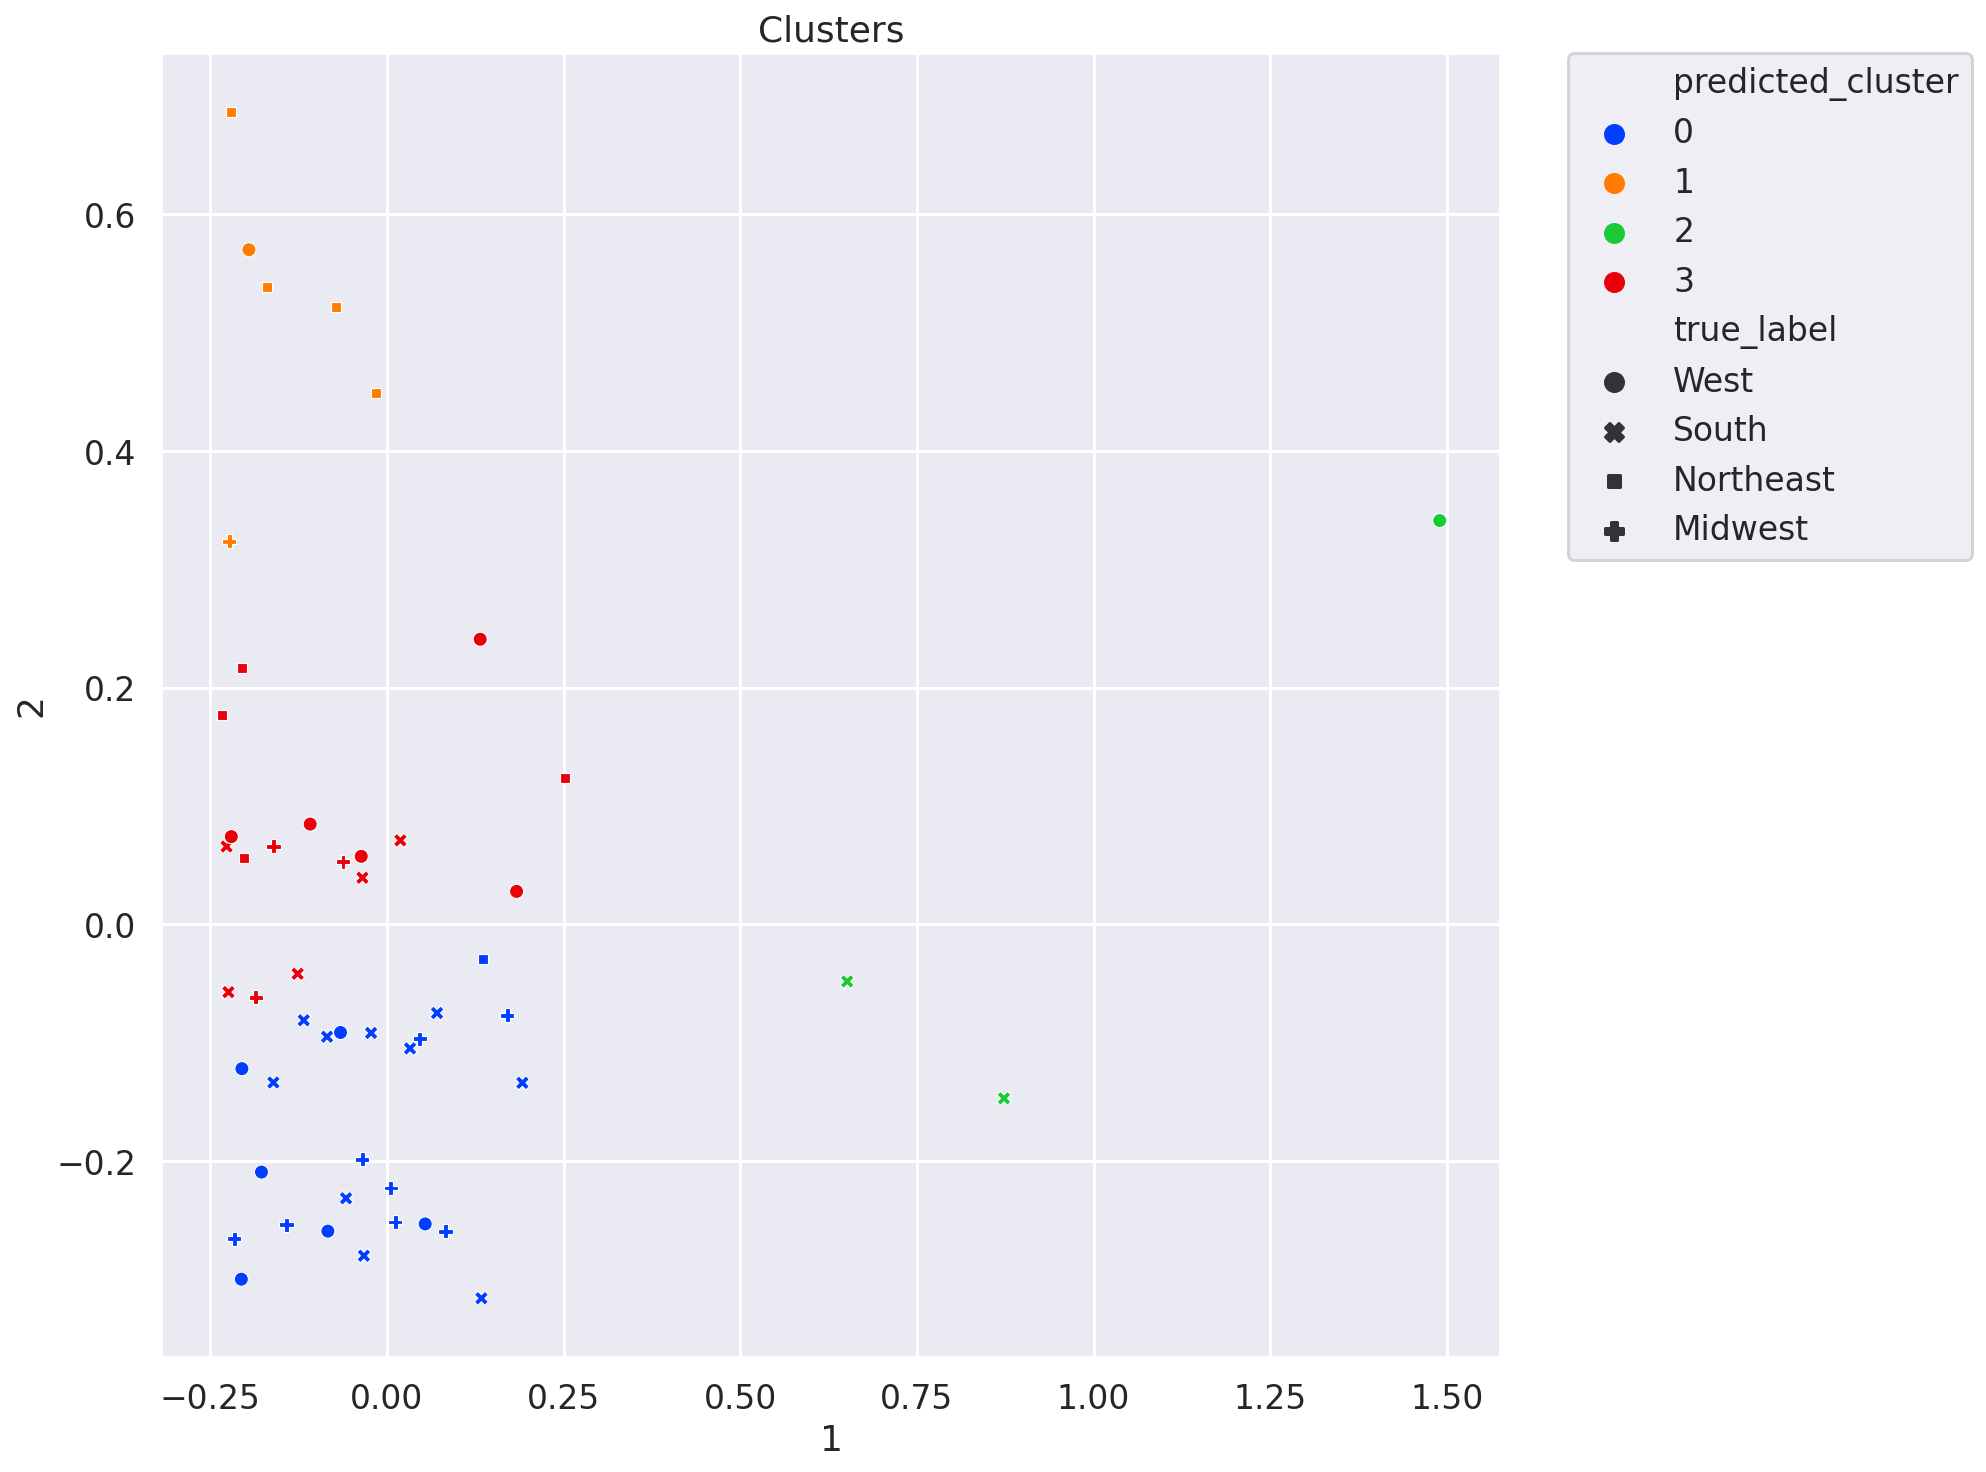

In [180]:
pcadf = pd.DataFrame(pipe["preprocessor"].transform(bonus_df), columns=["1", "2"])

pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
pcadf["true_label"] = label_encoder.inverse_transform(true_labels)

plt.figure(figsize=(12, 12))

scat = sns.scatterplot(
    x="1",
    y="2",
    s=50,
    data=pcadf,
    hue="predicted_cluster",
    style="true_label",
    palette="bright",
)

scat.set_title("Clusters")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()


## Conclusions

### 1) The vast majority of people killed are men.
### 2) The majority of people killed has attacked the police.
### 3) The majority of killings took place in with a switched off camera. 
### 4) The majority of criminals were shot.
### 5) The majority of people killed did not present signs of mental illness.
### 6) The majority of criminals did not flee.
### 7) 19 out of 20 victims are males.
### 8) White people are usually older when they get killed.
### 9) Black people are usually younger when they get killed.
### 10) In comparison to white people, black people get killed by police 2.5 times more often.
### 11) On average in America 5.7 people per 100K population die of police.
### 12) Top 5 states with higest deaths per capita: New Mexico, Alaska, Oklahoma, Arizona, Colorado.
### 13) Top 5 states with lowest deaths per capita: Rhode Island, Connecticut, New York, Massachusetts, New Jersey.
### 14) The BLM protests didn't reduce police violence.
### 15) Mental health check is important when selling guns.
### 16) Strict gun laws save lifes.